### Imports

In [1]:
# file handling
import csv
import glob
from PIL import Image
import imageio
import os
import requests
from PyPDF2 import PdfFileReader
from os import listdir
from os.path import isfile, join
import warnings


# text related tasks
from bs4 import BeautifulSoup
import regex as re


# data related
import numpy as np
import math
import pandas as pd 
import random
from scipy import stats


# data visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.ticker as mtick
import seaborn as sb
import squarify as sq
from pySankey.sankey import sankey
from statsmodels.graphics.gofplots import qqplot


# ML Libraries :
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from minisom import MiniSom
from yellowbrick.style import set_palette
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# setups
%matplotlib inline
sb.set()

warnings.filterwarnings("ignore")


### Methods


In [2]:
# this section contains this work's user defined methods

def outliers(feature):
# Prints an outlier resume about one feature
    # calculate interquartile range
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25
    print(f'{feature.name.upper()}')
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in feature if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    non_outliers = [x for x in feature if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(non_outliers))
    proportion = len(outliers)/len(non_outliers)*100
    print(f'Outlier Percentage: {proportion:.2f} %\n')
    

def select_features(X_train, y_train, X_test):
    # Select all features
    fs = SelectKBest(score_func=f_classif, k='all' )
    
    # Learn relationship from training data
    fs.fit(X_train, y_train)
   
    return fs


def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


def treemap_lite(lst, str_name): 
    
    # copy loop trough years and make a grid for each one
    year = 2015
    while year < 2020:

        # set figure
        fig, axes = plt.subplots(2, 2, figsize=(12, 9))
        plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
        # set counters for subplots
        i = 0
        j = 0

        for hood_name in lst:
            # counters logic
            if j > 1:
                j = 0
                i += 1
                
            axes[i, j].set_title(hood_name + ' ' + str(year), fontsize=18)

            # select slices to use as data
            aux = df.loc[(df['year']==year)&(df['neighbourhood']==hood_name),
                            ['housing','commerce','industry','offices','hotel/rest',
                             'communitary_group', 'sports','other_uses']].values.flatten().tolist()
            # write labels
            labels = ['housing','retail','industry','offices','hotel/rest','health +\neducation+\nparkings...', 'sports', 'others']
            mpl.rcParams['font.size'] = 12    

            # plot treemap
            sq.plot(sizes=aux,
                    label=labels,
                    color=['silver', 'gold', 'burlywood', 'orangered', 'lime', 'blueviolet','olivedrab', 'dodgerblue'],
                    alpha=0.9,
                    ax=axes[i,j])

            # remove axis for a cleaner plot
            axes[i, j].axis('off')

            # update counters
            j += 1     
                
        # show/save plot
        plt.subplots_adjust(wspace=0.09, hspace=0.12)
        path_imgs = 'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\animations\\'+ str_name +'\\'+ str_name + str(year) + '.png'
        plt.savefig(path_imgs, bbox_inches='tight')

        plt.close()

        # update year
        year += 1 
        
    # create animation

    # filepaths
    fp_in = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\animations\\'+ str_name + '/*.png'
    fp_out = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\'+ str_name + '.gif'

    imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
    img = next(imgs)
    img.save(fp=fp_out, format='GIF', append_images=imgs,save_all=True, duration=2000, loop=0)



## Pre-Processing
___


### Missing Values

Let's see how many values are missing

In [35]:
df.isna().sum()

year                                   0
neighbourhood                          0
population                             0
% strangers                            0
% w/ higher education                  0
total_surface(m2)                      0
housing(m2)                            0
parking(m2)                            0
commerce(m2)                           0
industry(m2)                           0
offices(m2)                            0
education(m2)                          0
healthcare(m2)                         0
hostelry(m2)                           0
sports(m2)                             0
religious(m2)                          0
entertainment(m2)                      0
other_uses(m2)                         0
avg_€/month                           14
avg_€/m2                              14
avg_housing(m2)                       14
win_lost_rents_1000_hab                0
disp_income(€/year)                    0
gini_index(%)                          0
new_household_pu

There's two groups so when trying to imputate we could use following methods:
- *Rent prices*:
   
    1. One could be to find the average of the prices from the other neighbourhoods that share district with it, the downside might be that higher price differences inside the same district could offer irrealistic values for the zones we are interested to imputate.
    
    2. We could also calculate the average change in percentage for the other neighbourhoods from the same district, and select the more similar neighbourhoods (w/ similar prices).
    
    
- *Purchase prices*: 

    1. There's not much we could do with the "new_household_purchases(x1000€)" feature, having more than 50% of it's data missing. So we'll drop it. 
        
    2. "Total_household_purchases(x1000€)" on the contrary only has 7 points missing so we could follow both methods exposed before as well.

### Avg €/m2 Imputation

In [36]:
# get missing rent prices
aux = df.loc[df['avg_€/m2'].isna()]
aux.sort_values(by=['neighbourhood']).filter(['year', 'neighbourhood', 'district'])

,year,neighbourhood,district
146,2017,Baró de Viver,Sant Andreu
292,2019,Baró de Viver,Sant Andreu
2,2015,Can Peguera,Nou Barris
221,2018,Can Peguera,Nou Barris
294,2019,Can Peguera,Nou Barris
315,2019,Torre Baró,Nou Barris
243,2018,Vallbona,Nou Barris
316,2019,Vallbona,Nou Barris
123,2016,la Clota,Horta-Guinardó
196,2017,la Clota,Horta-Guinardó


Once the district column is added we can get the average price for each district that has missing values (method1)

In [37]:
# get them Districts avg price for every year
baro17 = df.loc[(df['district']=='Sant Andreu') & (df['year']==2017)].groupby(by=['district'])['avg_€/m2'].agg('mean')
baro19 = df.loc[(df['district']=='Sant Andreu') & (df['year']==2019)].groupby(by=['district'])['avg_€/m2'].agg('mean')

print('Sant Andreu mean price 2017\n', baro17, '\n')
print('Sant Andreu mean price 2019\n', baro19, '\n')

Sant Andreu mean price 2017
 district
Sant Andreu    10.765
Name: avg_€/m2, dtype: float64 

Sant Andreu mean price 2019
 district
Sant Andreu    11.708333
Name: avg_€/m2, dtype: float64 



>Method nº1 doesn't seem to offer realistic prices since inside each district there's a lot of variance in prices, so we better discard this method and go for for the percentage change method (method nº2)
>
>🙅🏾‍♂️ <span style="color:greenyellow;"> Friendsh</span><span style="color:palegreen;">ip ended wi</span><span style="color:plum;">th Method nº</span><span style="color:mediumpurple;">1, now Method nº2 is m</span><span style="color:darkviolet;">y best friend!!</span>  👨🏾

In [38]:
# method 2: Compute percentage change per year & hood inside the same district

# sort df
df = df.sort_values(by=['year','district', 'neighbourhood'], ignore_index=True)

In [39]:
#define functions to get prices for district and percent changes in price 
def prices(year, district, column):
    aux = df[str(column)].loc[ (df['year']==year) & (df['district']==str(district)) ]
    aux = pd.DataFrame(aux).reset_index(drop=True)
    return aux


def changes(district, column):
    i = 0
    for x in range(2015,2020,1):
        aux = prices(x, district, column)
        if i == 0:
            good = aux
        else:
            good = pd.concat((good,aux), axis=1, ignore_index=True )
        i +=1
    
    # transpose df
    good = good.T
   
    # name columns reusing the dictionary (made before) containing district:[neighbourhoods]
    good.columns = sorted(d[district])
    
    # display prices as well to know the differences
    good_value = good
    
    # apply percent change method
    good_pct = good.pct_change()
    
    return [good_value, good_pct]




- Sant Andreu District

In [40]:
# check price and variations
price = changes('Sant Andreu', 'avg_€/m2')[0]
variations = changes('Sant Andreu', 'avg_€/m2')[1]
#display(price)
#display(variations)

In [41]:
# Baró de Viver (2017 & 2019)

# get index (2017
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Baró de Viver') & (df['year']==2017)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[2],[3,6]].values.mean())*0.03515) + 3.515

# get index (2019)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Baró de Viver') & (df['year']==2019)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[4],[3,6]].values.mean())*0.076) + 7.6

- Nou Barris District

In [42]:
# check price and variations
price = changes('Nou Barris', 'avg_€/m2')[0]
variations = changes('Nou Barris', 'avg_€/m2')[1]
#display(price)
#display(variations)

In [43]:
# Torre baro 2019 
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Torre Baró') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[4],[1,2,8,9]].values.mean())*0.0722) + 7.22

In [44]:
# Vallbona 2018 & 2019

# get index (2018)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Vallbona') & (df['year']==2018)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[3],[1,2,8,9]].values.mean())*0.0445) + 4.45
# get value obtained for calculating next year (missing as well)
price_2018 = df.loc[[ix],['avg_€/m2']].values

# next index(2019)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Vallbona') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[4],[1,2,8,9]].values.mean())*(price_2018 / 100)) + price_2018

In [45]:
# Can Peguera 2018, 2019 and 2015

# get index (2018)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2018)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[3],[1,2,8,9]].values.mean())*0.1168) + 11.68
# get value obtained for calculating next year (missing as well)
price_2018 = df.loc[[ix],['avg_€/m2']].values

# next index (2019)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[4],[1,2,8,9]].values.mean())*price_2018/100) + price_2018

# next index (2015)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2015)].index.astype(int)[0]
# since it's the first value missing in the column, in this case the percent change method has to go backwards in time
price =changes('Nou Barris', 'avg_€/m2')[0] # cast again with prices actualized
inverse = price.pct_change(periods=-1) # inverse
# imputate
df.loc[[ix],['avg_€/m2']] =  ((inverse.iloc[[0],[1,2,8,9]].values.mean())*0.1051) + 10.51


- Sants-Montjuïc District

In [46]:
# check price and variations
price = changes("Sants-Montjuïc", 'avg_€/m2')[0]
variations = changes("Sants-Montjuïc", 'avg_€/m2')[1]
#display(price)
#display(variations)

In [47]:
# la Marina del Prat Vermell (2017 & 2018)

# get index (2017)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='la Marina del Prat Vermell') & (df['year']==2017)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[2],[4,6]].values.mean())*0.0696) + 6.96

# next index (2018)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='la Marina del Prat Vermell') & (df['year']==2018)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/m2']] =  ((variations.iloc[[2],[4,6]].values.mean())*0.06968841) + 6.968841


In [48]:
#check missing rent
aux = df.loc[df['avg_€/m2'].isna()]
aux.sort_values(by=['neighbourhood']).filter(['year', 'neighbourhood', 'district'])

,year,neighbourhood,district
95,2016,la Clota,Horta-Guinardó
168,2017,la Clota,Horta-Guinardó
241,2018,la Clota,Horta-Guinardó
314,2019,la Clota,Horta-Guinardó


la Clota neighbourhood has too much missing data, so we'll drop it from database 

In [49]:
# drop neighbourhood
df.drop(df[(df['neighbourhood']=='la Clota')].index, inplace=True)

### Avg €/month Imputation

In [50]:
# get missing rent prices
aux = df.loc[df['avg_€/month'].isna()]
aux.sort_values(by=['neighbourhood']).filter(['year', 'neighbourhood', 'district'])

,year,neighbourhood,district
188,2017,Baró de Viver,Sant Andreu
334,2019,Baró de Viver,Sant Andreu
29,2015,Can Peguera,Nou Barris
248,2018,Can Peguera,Nou Barris
321,2019,Can Peguera,Nou Barris
325,2019,Torre Baró,Nou Barris
253,2018,Vallbona,Nou Barris
326,2019,Vallbona,Nou Barris
212,2017,la Marina del Prat Vermell,Sants-Montjuïc
285,2018,la Marina del Prat Vermell,Sants-Montjuïc


- Sant Andreu District

In [51]:
# check prices and variations
price = changes('Sant Andreu', 'avg_€/month')[0]
variations = changes('Sant Andreu', 'avg_€/month')[1]
#display(price)
#display(variations)

In [52]:
# Baró de Viver (2017 & 2019)

# get index (2017)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Baró de Viver') & (df['year']==2017)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[2],[3,6]].values.mean())*1.99395) + 199.395

# get index (2019)
ix = df['avg_€/m2'].loc[(df['neighbourhood']=='Baró de Viver') & (df['year']==2019)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[4],[3,6]].values.mean())*6.73690) + 673.690

- Nou Barris District

In [53]:
# check prices and variations
price = changes('Nou Barris', 'avg_€/month')[0]
variations = changes('Nou Barris', 'avg_€/month')[1]
#display(price)
#display(variations)

In [54]:
# Torre baro 2019 
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Torre Baró') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[4],[2,6,8,9,11,12]].values.mean())*4.3452) + 434.520

In [55]:
# Vallbona 2018 & 2019

# get index (2018)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Vallbona') & (df['year']==2018)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[3],[2,6,8,9,11,12]].values.mean())*3.0252) + 302.52
# get value obtained for calculating next year (missing as well)
price_2018 = df.loc[[ix],['avg_€/month']].values

# next index(2019)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Vallbona') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[4],[2,6,8,9,11,12]].values.mean())*(price_2018 / 100)) + price_2018

In [56]:
# Can Peguera 2018, 2019 and 2015

# get index (2018)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2018)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[3],[2,6,8,9,11,12]].values.mean())*4.0722) + 407.22
# get value obtained for calculating next year (missing as well)
price_2018 = df.loc[[ix],['avg_€/month']].values

# next index (2019)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2019)].index.astype(int)[0]
# imputate
df.loc[[ix],['avg_€/month']] =  (variations.iloc[[4],[2,6,8,9,11,12]].values.mean())*(price_2018 / 100) + price_2018

# next index (2015)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2015)].index.astype(int)[0]
# since it's the first value missing in the column, in this case the percent change method has to go backwards in time
price =changes('Nou Barris', 'avg_€/m2')[0] # cast again with prices actualized
inverse = price.pct_change(periods=-1) # inverse
# imputate
df.loc[[ix],['avg_€/month']] =  ((inverse.iloc[[0],[2,6,8,9,11,12]].values.mean())*3.0182) + 301.82

- Sants-Montjuïc District

In [57]:
# check prices and variations
price = changes("Sants-Montjuïc", 'avg_€/month')[0]
variations = changes("Sants-Montjuïc", 'avg_€/month')[1]
#display(price)
#display(variations)

In [58]:
# la Marina del Prat Vermell (2017 & 2018)

# get index (2017)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='la Marina del Prat Vermell') & (df['year']==2017)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/month']] =  ((variations.iloc[[2],[4,6]].values.mean())*3.60880) + 360.880
# get value obtained for calculating next year (missing as well)
price_2017 = df.loc[[ix],['avg_€/month']].values

# next index (2018)
ix = df['avg_€/month'].loc[(df['neighbourhood']=='la Marina del Prat Vermell') & (df['year']==2018)].index.astype(int)[0]
# impute
df.loc[[ix],['avg_€/month']] =  (variations.iloc[[2],[4,6]].values.mean())*(price_2017 / 100) + price_2017


### Total household purchase prices imputation

In [59]:
# get missing purchase prices
aux = df.loc[df['Total_household_purchases(x1000€)'].isna()]
aux.sort_values(by=['neighbourhood']).filter(['year', 'neighbourhood', 'district'])

,year,neighbourhood,district
334,2019,Baró de Viver,Sant Andreu
321,2019,Can Peguera,Nou Barris
33,2015,Torre Baró,Nou Barris
66,2015,la Marina del Prat Vermell,Sants-Montjuïc


- Sant Andreu District

In [60]:
# check prices and variations
price = changes('Sant Andreu', 'Total_household_purchases(x1000€)')[0]
variations = changes('Sant Andreu', 'Total_household_purchases(x1000€)')[1]
#display(price)
#display(variations)

In [61]:
# Baró de Viver (2019)

# get index 
ix = df['Total_household_purchases(x1000€)'].loc[(df['neighbourhood']=='Baró de Viver') & (df['year']==2019)].index.astype(int)[0]
# impute
df.loc[[ix],['Total_household_purchases(x1000€)']] =  ((variations.iloc[[4],[3,6]].values.mean())*2.813) + 281.3

- Nou Barris District

In [62]:
# check prices and variations
price = changes('Nou Barris', 'Total_household_purchases(x1000€)')[0]
variations = changes('Nou Barris', 'Total_household_purchases(x1000€)')[1]
#display(price)
#display(variations)

In [63]:
# Can Peguera (2019)

# get index 
ix = df['Total_household_purchases(x1000€)'].loc[(df['neighbourhood']=='Can Peguera') & (df['year']==2019)].index.astype(int)[0]
# impute
df.loc[[ix],['Total_household_purchases(x1000€)']] =  ((variations.iloc[[4],[2,6,8,9,11,12]].values.mean())*1.018) + 101.8

In [64]:
# Torre baro 2015 
ix = df['Total_household_purchases(x1000€)'].loc[(df['neighbourhood']=='Torre Baró') & (df['year']==2015)].index.astype(int)[0]

# since it's the first value missing in the column, in this case the percent change method has to go backwards in time
# cast again with prices actualized
price =changes('Nou Barris', 'Total_household_purchases(x1000€)')[0]
# inverse
inverse = price.pct_change(periods=-1) 
display(inverse)
# imputate
df.loc[[ix],['Total_household_purchases(x1000€)']] =  ((inverse.iloc[[0],[2,6,8,9,11,12]].values.mean())*1.1) + 110.0

,Can Peguera,Canyelles,Ciutat Meridiana,Porta,Torre Baró,Vallbona,Verdun,Vilapicina i la Torre Llobeta,el Turó de la Peira,la Guineueta,la Prosperitat,la Trinitat Nova,les Roquetes
0,0.455696,-0.096491,-0.025890,-0.016058,NaN,0.171913,0.022088,-0.074099,-0.075526,0.060797,-0.075455,-0.040299,-0.547456
1,-0.516608,0.063764,-0.198444,-0.198830,0.134021,-0.298017,-0.147260,-0.131594,-0.029685,-0.182286,-0.126515,-0.089674,0.234302
2,0.123772,-0.170858,-0.138547,0.069418,0.182927,0.086154,-0.142438,-0.150665,-0.180228,-0.088542,-0.004525,-0.143190,-0.400898
3,-0.000505,-0.088585,0.027850,-0.097884,-0.456954,0.354731,-0.094716,-0.003312,-0.136431,-0.097108,-0.039652,0.014767,0.026069
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Sants-Montjuïc District

In [65]:
# check prices and variations
price = changes("Sants-Montjuïc", 'Total_household_purchases(x1000€)')[0]
variations = changes("Sants-Montjuïc", 'Total_household_purchases(x1000€)')[1]
display(price)
display(variations)

,Hostafrancs,Sants,Sants - Badal,el Poble Sec - Parc Montjuïc,la Bordeta,la Font de la Guatlla,la Marina de Port,la Marina del Prat Vermell
0,169.500,166.600,115.900,143.000,191.90,174.500,139.20,NaN
1,199.100,222.800,181.300,155.200,155.90,173.800,151.10,79.3
2,263.300,338.300,251.500,260.500,288.10,235.100,166.30,99.1
3,247.100,241.300,234.400,225.500,263.70,301.900,193.30,89.3
4,319.925,270.025,243.475,283.925,194.95,292.325,185.05,121.0


,Hostafrancs,Sants,Sants - Badal,el Poble Sec - Parc Montjuïc,la Bordeta,la Font de la Guatlla,la Marina de Port,la Marina del Prat Vermell
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.174631,0.337335,0.564280,0.085315,-0.187598,-0.004011,0.085489,NaN
2,0.322451,0.518402,0.387204,0.678479,0.847979,0.352704,0.100596,0.249685
3,-0.061527,-0.286728,-0.067992,-0.134357,-0.084693,0.284134,0.162357,-0.098890
4,0.294719,0.119043,0.038716,0.259091,-0.260713,-0.031716,-0.042680,0.354983


In [66]:
# la Marina del Prat Vermell (2015)

# get index (2015)
ix = df['Total_household_purchases(x1000€)'].loc[(df['neighbourhood']=='la Marina del Prat Vermell') & (df['year']==2015)].index.astype(int)[0]

# since it's the first value missing in the column, in this case the percent change method has to go backwards in time
# cast again with prices actualized
price =changes('Sants-Montjuïc', 'Total_household_purchases(x1000€)')[0]
# inverse
inverse = price.pct_change(periods=-1) 
display(inverse)
# impute
df.loc[[ix],['Total_household_purchases(x1000€)']] =  ((inverse.iloc[[0],[4,6]].values.mean())*0.793) + 79.3


,Hostafrancs,Sants,Sants - Badal,el Poble Sec - Parc Montjuïc,la Bordeta,la Font de la Guatlla,la Marina de Port,la Marina del Prat Vermell
0,-0.148669,-0.252244,-0.360728,-0.078608,0.230917,0.004028,-0.078756,NaN
1,-0.243828,-0.341413,-0.279125,-0.404223,-0.458868,-0.260740,-0.091401,-0.199798
2,0.065561,0.401989,0.072952,0.155211,0.092529,-0.221265,-0.139679,0.109742
3,-0.227631,-0.106379,-0.037273,-0.205776,0.352655,0.032755,0.044583,-0.261983
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### New household purchase prices imputation

In [67]:
# get missing purchase prices
aux = df.loc[df['new_household_purchases(x1000€)'].isna()]
aux.sort_values(by=['neighbourhood']).filter(['year', 'neighbourhood', 'district'])

,year,neighbourhood,district
261,2018,Baró de Viver,Sant Andreu
115,2016,Baró de Viver,Sant Andreu
334,2019,Baró de Viver,Sant Andreu
42,2015,Baró de Viver,Sant Andreu
188,2017,Baró de Viver,Sant Andreu
...,...,...,...
260,2018,les Roquetes,Nou Barris
333,2019,les Roquetes,Nou Barris
114,2016,les Roquetes,Nou Barris
291,2018,les Tres Torres,Sarrià-Sant Gervasi


There's too much info missing in new household purchases, so we decide to drop it, along with the district column we used.

In [68]:
df.drop(columns=['new_household_purchases(x1000€)', 'district'], axis=1, inplace=True)

In [69]:
df.drop(['protected_household_purchases','total_surface(m2)','parking(m2)', 'avg_€/month','avg_housing(m2)','healthcare(m2)','education(m2)','religious(m2)','sports(m2)','industry(m2)', 'communitary_group(m2)','other_uses(m2)', 'entertainment(m2)'], axis=1, inplace=True)

In [70]:
# check missing values
df.isna().sum()

year                                 0
neighbourhood                        0
population                           0
% strangers                          0
% w/ higher education                0
housing(m2)                          0
commerce(m2)                         0
offices(m2)                          0
hostelry(m2)                         0
avg_€/m2                             0
win_lost_rents_1000_hab              0
disp_income(€/year)                  0
gini_index(%)                        0
new_household_purchases              0
used_household_purchases             0
Total_household_purchases(x1000€)    0
%_unemployed                         0
dtype: int64

### Presence of outliers

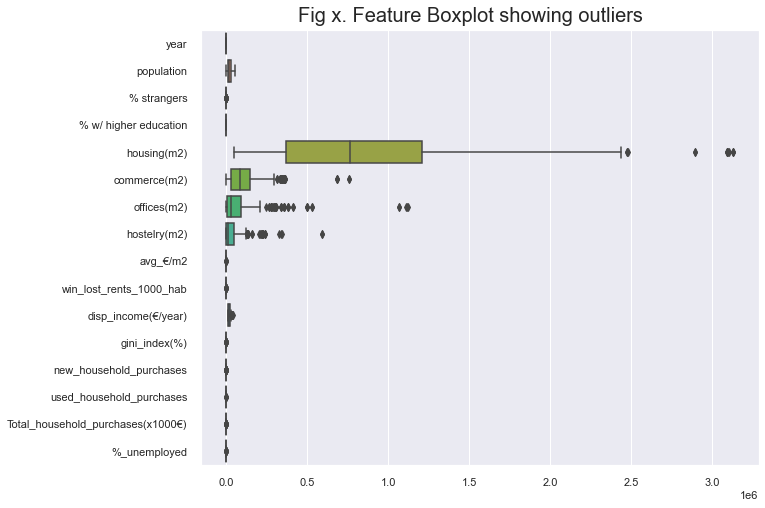

In [71]:
# checking outliers
fig = plt.figure(figsize=(10,8))
sb.boxplot(data=df,orient='h' )
plt.suptitle('Fig x. Feature Boxplot showing outliers', fontsize=20, y=0.92)
plt.show()
plt.close()

In [72]:
for x in range(2,17):
    outliers(df.iloc[:,x])

POPULATION
Percentiles: 25th=11264.250, 75th=31388.500, IQR=20124.250
Identified outliers: 0
Non-outlier observations: 360
Outlier Percentage: 0.00 %

% STRANGERS
Percentiles: 25th=12.800, 75th=20.600, IQR=7.800
Identified outliers: 23
Non-outlier observations: 337
Outlier Percentage: 6.82 %

% W/ HIGHER EDUCATION
Percentiles: 25th=16.200, 75th=39.100, IQR=22.900
Identified outliers: 0
Non-outlier observations: 360
Outlier Percentage: 0.00 %

HOUSING(M2)
Percentiles: 25th=372454.750, 75th=1209821.000, IQR=837366.250
Identified outliers: 13
Non-outlier observations: 347
Outlier Percentage: 3.75 %

COMMERCE(M2)
Percentiles: 25th=33675.000, 75th=146171.250, IQR=112496.250
Identified outliers: 25
Non-outlier observations: 335
Outlier Percentage: 7.46 %

OFFICES(M2)
Percentiles: 25th=6908.000, 75th=91642.000, IQR=84734.000
Identified outliers: 38
Non-outlier observations: 322
Outlier Percentage: 11.80 %

HOSTELRY(M2)
Percentiles: 25th=2629.250, 75th=51931.000, IQR=49301.750
Identified outli

### Feature Distribution & Transforms

In [73]:
# get feature skew
num_feats = df.dtypes[df.dtypes != 'object'].index
skew_feats = df[num_feats].skew().sort_values(ascending=False)

# remove year column 
skew_feats.drop('year', inplace=True)
skewnes = pd.DataFrame({'skew': skew_feats})
display(skewnes)

,skew
offices(m2),4.138881
hostelry(m2),3.699938
new_household_purchases,3.260991
commerce(m2),2.361682
% strangers,2.010885
Total_household_purchases(x1000€),1.659981
housing(m2),1.279392
used_household_purchases,0.985376
%_unemployed,0.970736
disp_income(€/year),0.929951


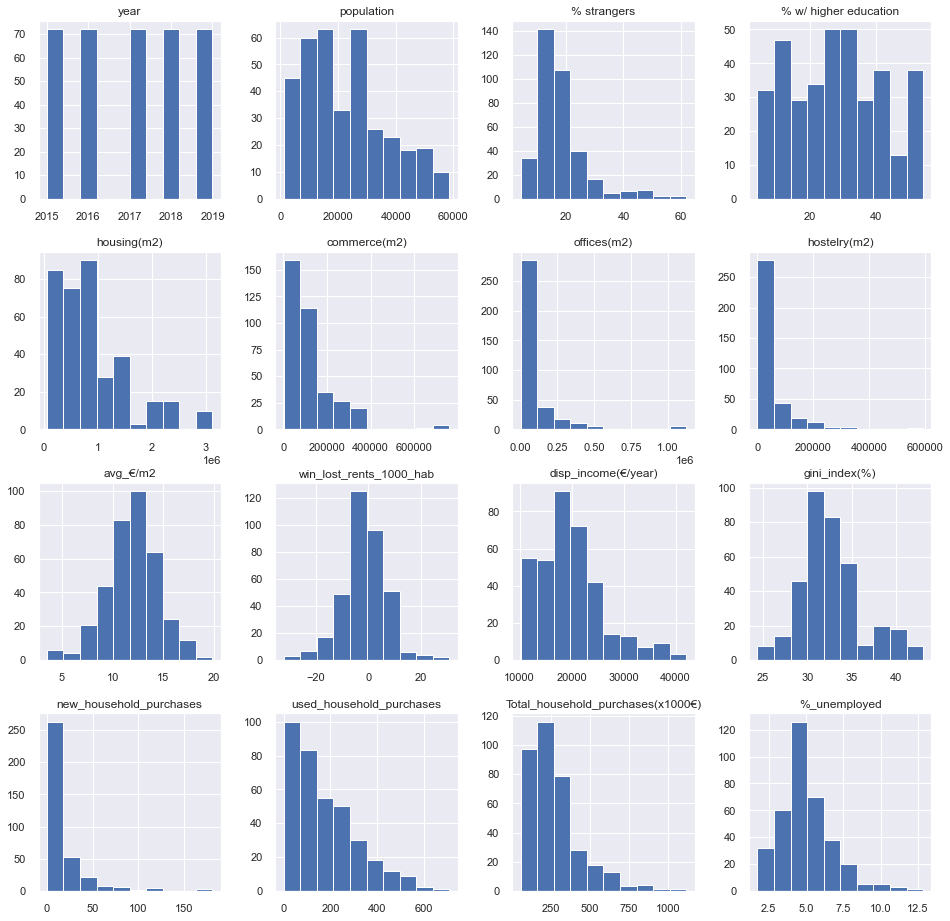

In [74]:
df.hist(figsize=(16,16))

plt.savefig(r"C:\Users\motxi\Documents\Data_Science_IT_Academy\PROJECTE\images\data_before_transformation.png",bbox_inches="tight")
plt.show()
plt.close()

We can see a mixture of distributions in the features, so the method for preprocesing will be:

- Applying Power Transformer to features.

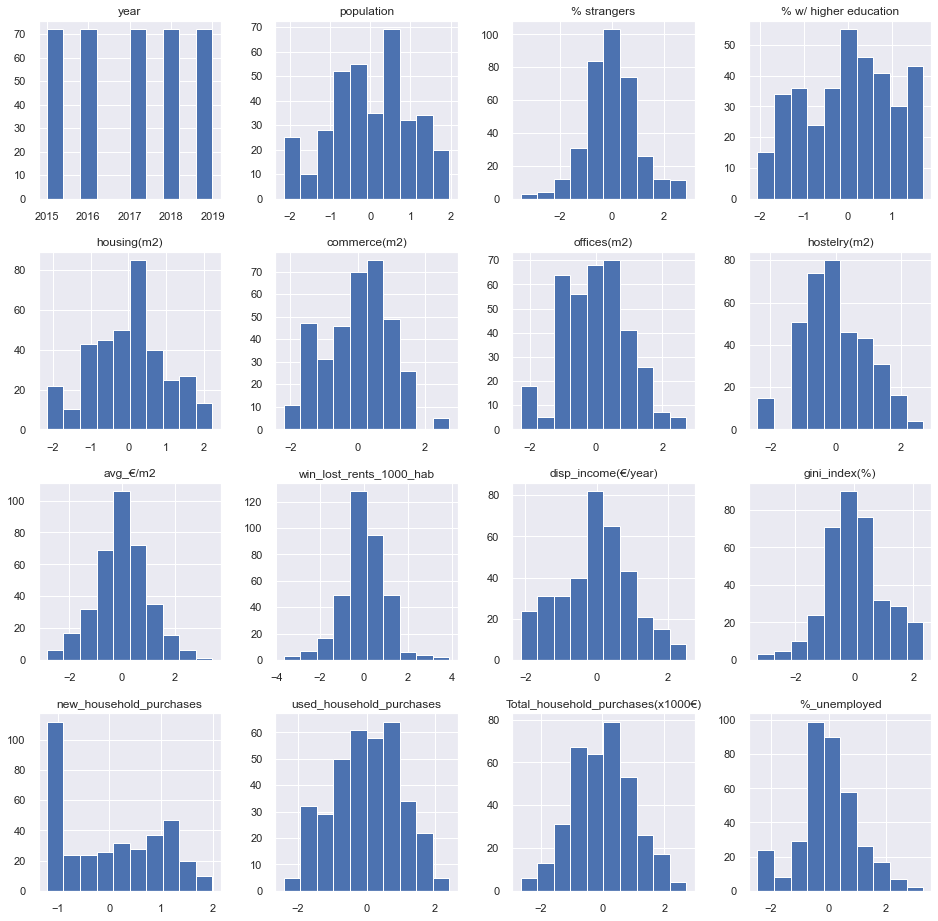

In [75]:
# apply transformations 
pt = PowerTransformer(method='yeo-johnson')
tr = pt.fit_transform(df.iloc[:,2:17])
tr = pd.DataFrame(tr)

df_tr = df.iloc[:,[0,1]]
df_tr.reset_index(drop=True, inplace=True)

df_tr = pd.concat([df_tr, tr], axis=1)
df_tr.columns=df.columns

# plot results after scaling
df_tr.hist(figsize=(16,16))

plt.savefig(r"C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\data_after_transformation.png",bbox_inches="tight")
plt.show()
plt.close()

>😒 Bad news is "new_household_purchases" column will have to be dropped since we couldn't fit it to "Gaussian" shape besides its distribution amongst the neighbourhoods is pretty residual and sparse, so it's not like we are missing a lot with a feature wich percentile 25th is 0

In [76]:
df_tr.drop('new_household_purchases', axis=1, inplace=True)

In [77]:
# store df per year in a dict
d = { x : df_tr[df_tr['year']==x] for x in range(2015,2020,1) }

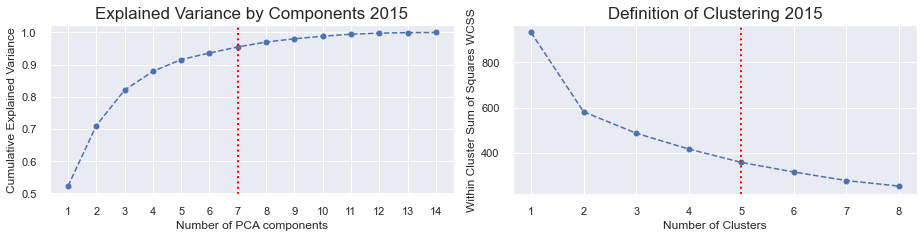

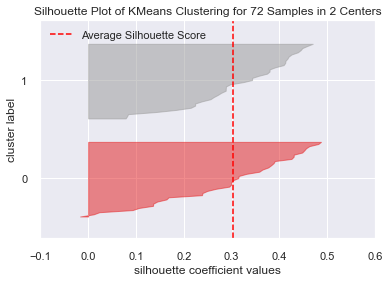

Silhouete Score for 2 Clusters: 0.3025168378093442



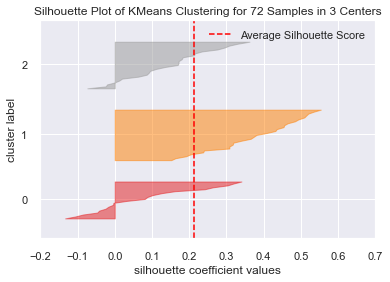

Silhouete Score for 3 Clusters: 0.2134384160465378



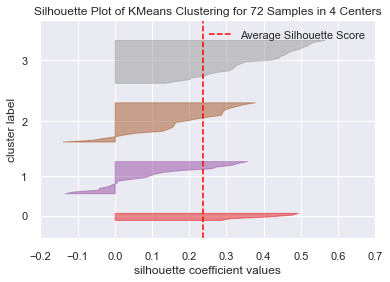

Silhouete Score for 4 Clusters: 0.2360223111889234



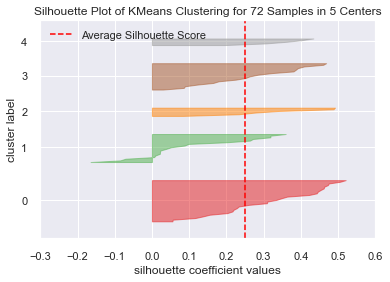

Silhouete Score for 5 Clusters: 0.25150575753906007



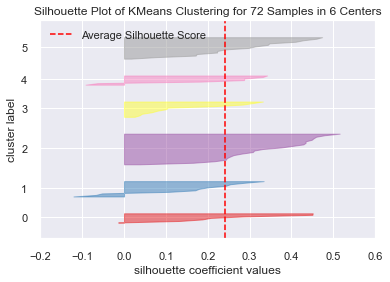

Silhouete Score for 6 Clusters: 0.24151487706872052



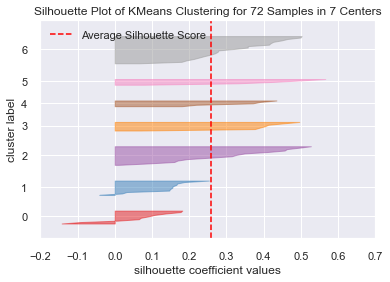

Silhouete Score for 7 Clusters: 0.26005969162019205



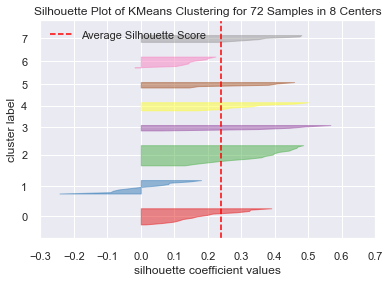

Silhouete Score for 8 Clusters: 0.24070383767724599

2015 Cluster Labels:--------------------------------


,Neighbourhood,Cluster
10,Vallcarca i els Penitents,Cluster 0
13,la Salut,Cluster 0
16,Horta,Cluster 0
19,el Baix Guinardó,Cluster 0
20,el Carmel,Cluster 0
21,el Guinardó,Cluster 0
22,la Font d'en Fargues,Cluster 0
31,Porta,Cluster 0
35,Vilapicina i la Torre Llobeta,Cluster 0
37,la Guineueta,Cluster 0


,Neighbourhood,Cluster
12,el Coll,Cluster 1
15,Can Baró,Cluster 1
17,Montbau,Cluster 1
18,Sant Genís dels Agudells,Cluster 1
23,la Teixonera,Cluster 1
24,la Vall d'Hebron,Cluster 1
28,Can Peguera,Cluster 1
29,Canyelles,Cluster 1
30,Ciutat Meridiana,Cluster 1
32,Torre Baró,Cluster 1


,Neighbourhood,Cluster
25,Pedralbes,Cluster 2
57,la Vila Olímpica del Poblenou,Cluster 2
67,Sant Gervasi - la Bonanova,Cluster 2
68,Sarrià,Cluster 2
69,Vallvidrera el Tibidabo i les Planes,Cluster 2
71,les Tres Torres,Cluster 2


,Neighbourhood,Cluster
4,Sant Antoni,Cluster 3
5,el Fort Pienc,Cluster 3
6,l'Antiga Esquerra de l'Eixample,Cluster 3
7,la Dreta de l'Eixample,Cluster 3
8,la Nova Esquerra de l'Eixample,Cluster 3
9,la Sagrada Família,Cluster 3
11,el Camp d'en Grassot i Gràcia Nova,Cluster 3
14,la Vila de Gràcia,Cluster 3
26,la Maternitat i Sant Ramon,Cluster 3
27,les Corts,Cluster 3


,Neighbourhood,Cluster
0,Sant Pere Santa Caterina i la Ribera,Cluster 4
1,el Barri Gòtic,Cluster 4
2,el Raval,Cluster 4
3,la Barceloneta,Cluster 4
61,el Poble Sec - Parc Montjuïc,Cluster 4


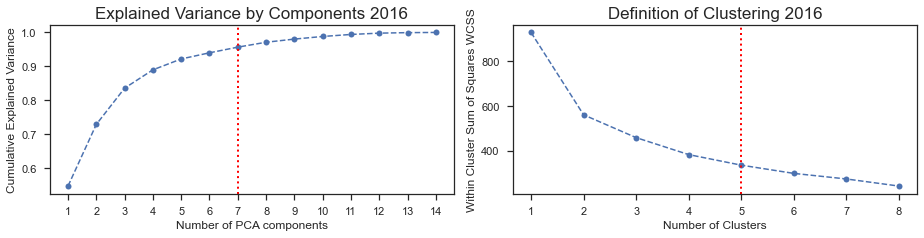

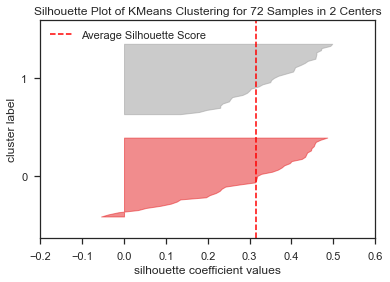

Silhouete Score for 2 Clusters: 0.3159544090096759



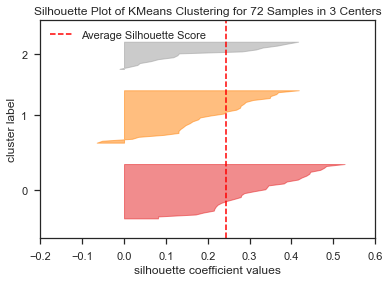

Silhouete Score for 3 Clusters: 0.24355996359013707



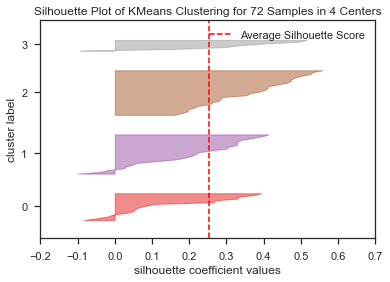

Silhouete Score for 4 Clusters: 0.25226592491867506



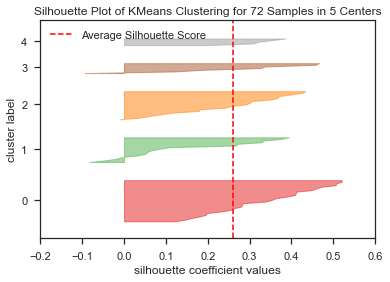

Silhouete Score for 5 Clusters: 0.25951499545733353



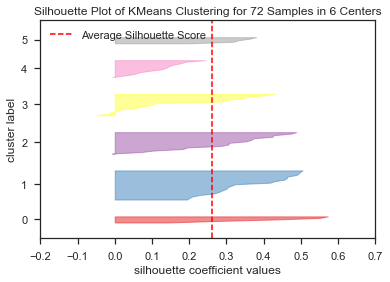

Silhouete Score for 6 Clusters: 0.2621621528508151



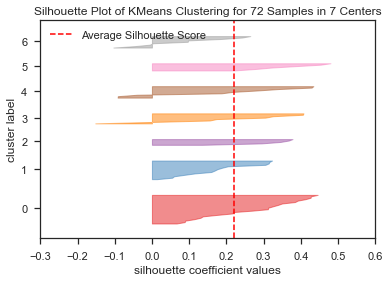

Silhouete Score for 7 Clusters: 0.21945358821924976



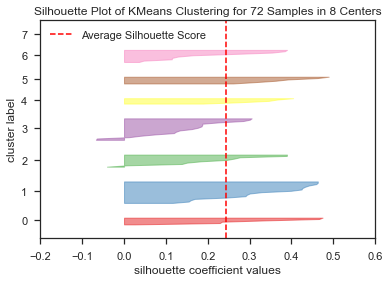

Silhouete Score for 8 Clusters: 0.24407915091683868

2016 Cluster Labels:--------------------------------


,Neighbourhood,Cluster
12,el Coll,Cluster 0
13,la Salut,Cluster 0
15,Can Baró,Cluster 0
16,Horta,Cluster 0
19,el Baix Guinardó,Cluster 0
20,el Carmel,Cluster 0
21,el Guinardó,Cluster 0
22,la Font d'en Fargues,Cluster 0
31,Porta,Cluster 0
35,Vilapicina i la Torre Llobeta,Cluster 0


,Neighbourhood,Cluster
17,Montbau,Cluster 1
18,Sant Genís dels Agudells,Cluster 1
23,la Teixonera,Cluster 1
24,la Vall d'Hebron,Cluster 1
28,Can Peguera,Cluster 1
29,Canyelles,Cluster 1
30,Ciutat Meridiana,Cluster 1
32,Torre Baró,Cluster 1
33,Vallbona,Cluster 1
34,Verdun,Cluster 1


,Neighbourhood,Cluster
4,Sant Antoni,Cluster 2
5,el Fort Pienc,Cluster 2
6,l'Antiga Esquerra de l'Eixample,Cluster 2
7,la Dreta de l'Eixample,Cluster 2
8,la Nova Esquerra de l'Eixample,Cluster 2
9,la Sagrada Família,Cluster 2
11,el Camp d'en Grassot i Gràcia Nova,Cluster 2
14,la Vila de Gràcia,Cluster 2
26,la Maternitat i Sant Ramon,Cluster 2
27,les Corts,Cluster 2


,Neighbourhood,Cluster
10,Vallcarca i els Penitents,Cluster 3
25,Pedralbes,Cluster 3
57,la Vila Olímpica del Poblenou,Cluster 3
67,Sant Gervasi - la Bonanova,Cluster 3
68,Sarrià,Cluster 3
69,Vallvidrera el Tibidabo i les Planes,Cluster 3
71,les Tres Torres,Cluster 3


,Neighbourhood,Cluster
0,Sant Pere Santa Caterina i la Ribera,Cluster 4
1,el Barri Gòtic,Cluster 4
2,el Raval,Cluster 4
3,la Barceloneta,Cluster 4
61,el Poble Sec - Parc Montjuïc,Cluster 4


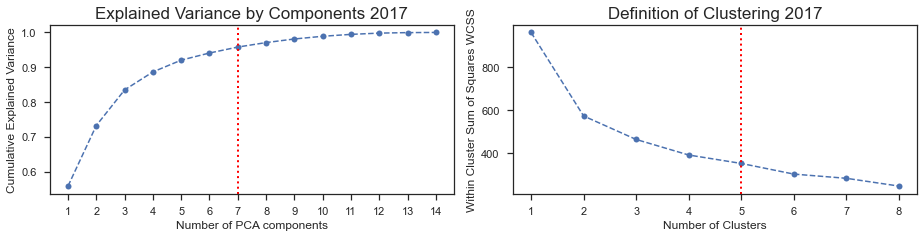

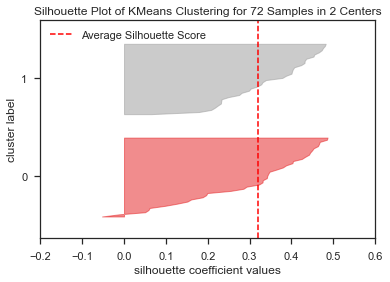

Silhouete Score for 2 Clusters: 0.32031376743121726



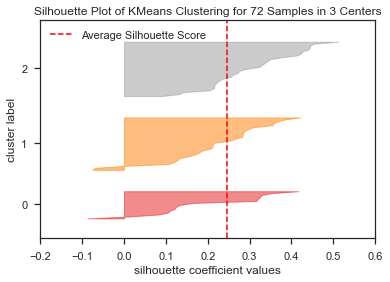

Silhouete Score for 3 Clusters: 0.24608042767647495



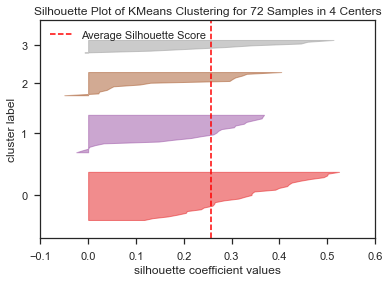

Silhouete Score for 4 Clusters: 0.2569575851179995



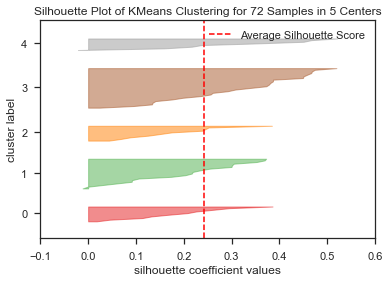

Silhouete Score for 5 Clusters: 0.242317639468642



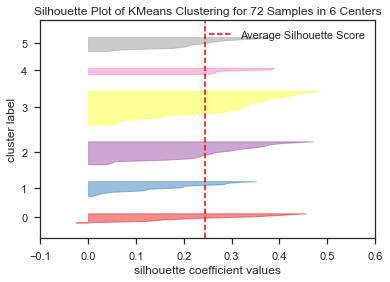

Silhouete Score for 6 Clusters: 0.24497638109187495



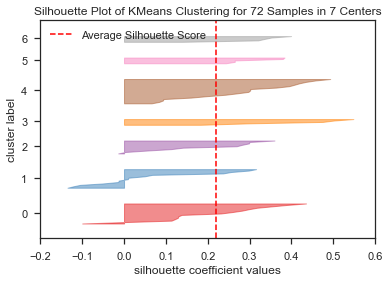

Silhouete Score for 7 Clusters: 0.22047557189260608



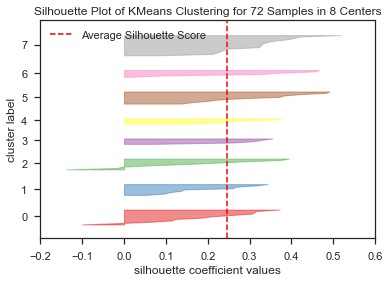

Silhouete Score for 8 Clusters: 0.24691267000813097

2017 Cluster Labels:--------------------------------


,Neighbourhood,Cluster
12,el Coll,Cluster 0
15,Can Baró,Cluster 0
17,Montbau,Cluster 0
18,Sant Genís dels Agudells,Cluster 0
22,la Font d'en Fargues,Cluster 0
23,la Teixonera,Cluster 0
24,la Vall d'Hebron,Cluster 0
28,Can Peguera,Cluster 0
29,Canyelles,Cluster 0
37,la Guineueta,Cluster 0


,Neighbourhood,Cluster
0,Sant Pere Santa Caterina i la Ribera,Cluster 1
1,el Barri Gòtic,Cluster 1
2,el Raval,Cluster 1
3,la Barceloneta,Cluster 1
4,Sant Antoni,Cluster 1
5,el Fort Pienc,Cluster 1
6,l'Antiga Esquerra de l'Eixample,Cluster 1
7,la Dreta de l'Eixample,Cluster 1
8,la Nova Esquerra de l'Eixample,Cluster 1
9,la Sagrada Família,Cluster 1


,Neighbourhood,Cluster
30,Ciutat Meridiana,Cluster 2
32,Torre Baró,Cluster 2
33,Vallbona,Cluster 2
34,Verdun,Cluster 2
36,el Turó de la Peira,Cluster 2
39,la Trinitat Nova,Cluster 2
40,les Roquetes,Cluster 2
41,Baró de Viver,Cluster 2
47,la Trinitat Vella,Cluster 2
65,la Marina del Prat Vermell,Cluster 2


,Neighbourhood,Cluster
11,el Camp d'en Grassot i Gràcia Nova,Cluster 3
13,la Salut,Cluster 3
16,Horta,Cluster 3
19,el Baix Guinardó,Cluster 3
20,el Carmel,Cluster 3
21,el Guinardó,Cluster 3
31,Porta,Cluster 3
35,Vilapicina i la Torre Llobeta,Cluster 3
38,la Prosperitat,Cluster 3
42,Navas,Cluster 3


,Neighbourhood,Cluster
10,Vallcarca i els Penitents,Cluster 4
25,Pedralbes,Cluster 4
57,la Vila Olímpica del Poblenou,Cluster 4
67,Sant Gervasi - la Bonanova,Cluster 4
68,Sarrià,Cluster 4
69,Vallvidrera el Tibidabo i les Planes,Cluster 4
70,el Putxet i el Farró,Cluster 4
71,les Tres Torres,Cluster 4


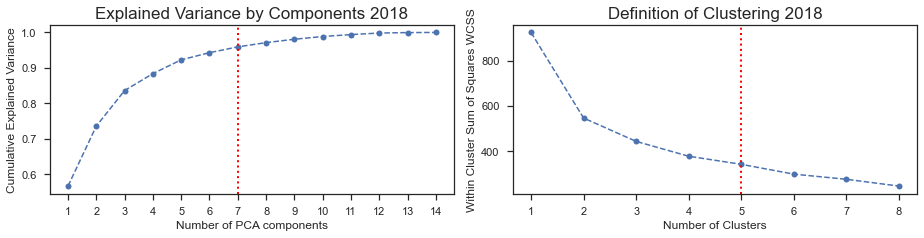

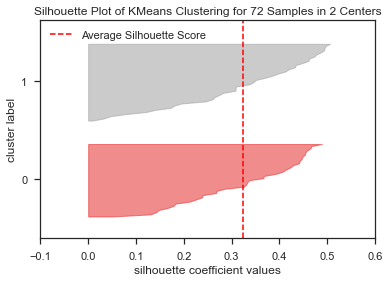

Silhouete Score for 2 Clusters: 0.32395671772064244



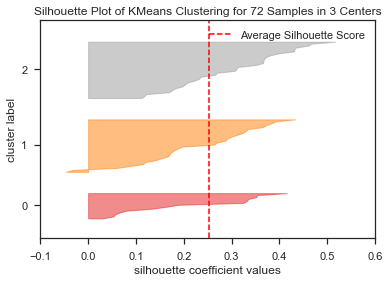

Silhouete Score for 3 Clusters: 0.25250590595580635



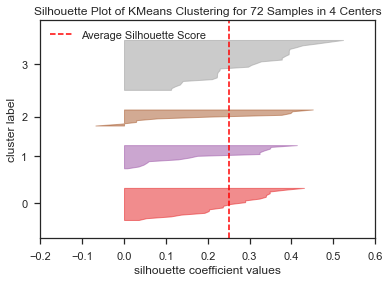

Silhouete Score for 4 Clusters: 0.2498252010144163



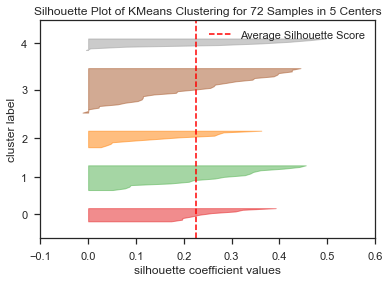

Silhouete Score for 5 Clusters: 0.22485731129722597



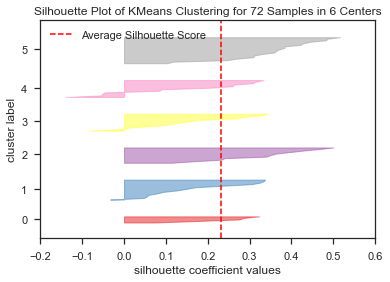

Silhouete Score for 6 Clusters: 0.23172316047913089



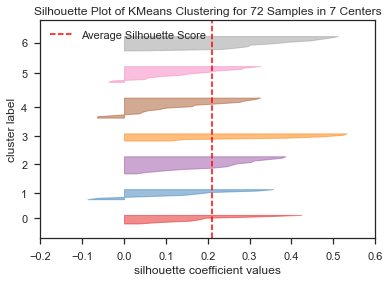

Silhouete Score for 7 Clusters: 0.21032320470488264



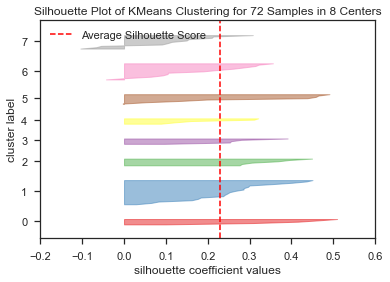

Silhouete Score for 8 Clusters: 0.22958792387529905

2018 Cluster Labels:--------------------------------


,Neighbourhood,Cluster
12,el Coll,Cluster 0
15,Can Baró,Cluster 0
17,Montbau,Cluster 0
18,Sant Genís dels Agudells,Cluster 0
22,la Font d'en Fargues,Cluster 0
23,la Teixonera,Cluster 0
24,la Vall d'Hebron,Cluster 0
29,Canyelles,Cluster 0
37,la Guineueta,Cluster 0


,Neighbourhood,Cluster
0,Sant Pere Santa Caterina i la Ribera,Cluster 1
1,el Barri Gòtic,Cluster 1
2,el Raval,Cluster 1
4,Sant Antoni,Cluster 1
5,el Fort Pienc,Cluster 1
6,l'Antiga Esquerra de l'Eixample,Cluster 1
7,la Dreta de l'Eixample,Cluster 1
8,la Nova Esquerra de l'Eixample,Cluster 1
9,la Sagrada Família,Cluster 1
11,el Camp d'en Grassot i Gràcia Nova,Cluster 1


,Neighbourhood,Cluster
28,Can Peguera,Cluster 2
30,Ciutat Meridiana,Cluster 2
32,Torre Baró,Cluster 2
33,Vallbona,Cluster 2
34,Verdun,Cluster 2
36,el Turó de la Peira,Cluster 2
39,la Trinitat Nova,Cluster 2
40,les Roquetes,Cluster 2
41,Baró de Viver,Cluster 2
47,la Trinitat Vella,Cluster 2


,Neighbourhood,Cluster
3,la Barceloneta,Cluster 3
10,Vallcarca i els Penitents,Cluster 3
13,la Salut,Cluster 3
16,Horta,Cluster 3
19,el Baix Guinardó,Cluster 3
20,el Carmel,Cluster 3
21,el Guinardó,Cluster 3
26,la Maternitat i Sant Ramon,Cluster 3
31,Porta,Cluster 3
35,Vilapicina i la Torre Llobeta,Cluster 3


,Neighbourhood,Cluster
25,Pedralbes,Cluster 4
48,Diagonal Mar i el Front Marítim del Poblenou,Cluster 4
57,la Vila Olímpica del Poblenou,Cluster 4
67,Sant Gervasi - la Bonanova,Cluster 4
68,Sarrià,Cluster 4
69,Vallvidrera el Tibidabo i les Planes,Cluster 4
70,el Putxet i el Farró,Cluster 4
71,les Tres Torres,Cluster 4


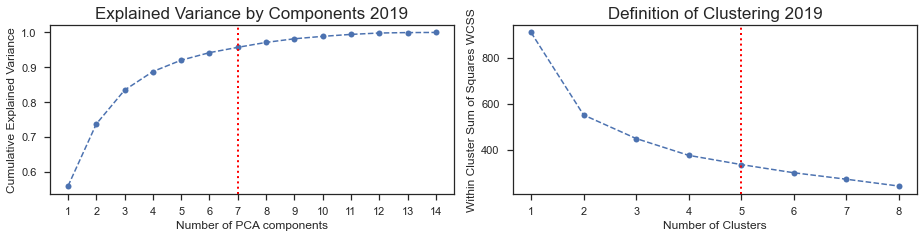

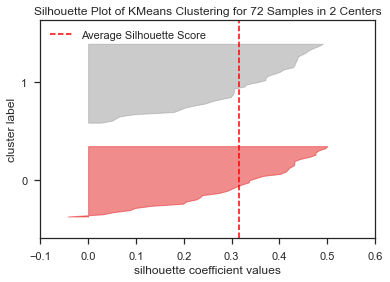

Silhouete Score for 2 Clusters: 0.3158576771006456



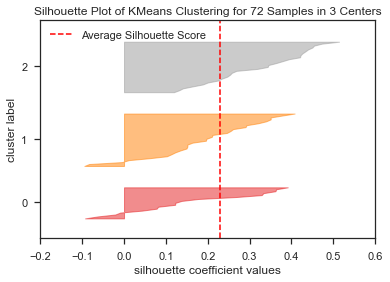

Silhouete Score for 3 Clusters: 0.2292735233595003



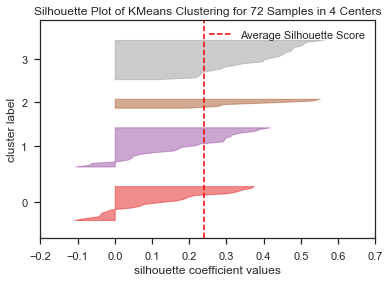

Silhouete Score for 4 Clusters: 0.2408992051161994



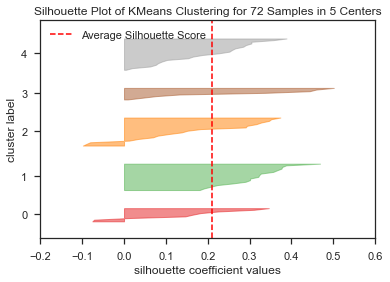

Silhouete Score for 5 Clusters: 0.2107750401743576



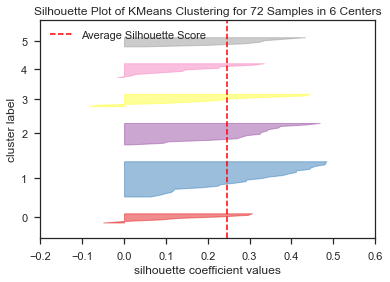

Silhouete Score for 6 Clusters: 0.24509174507508524



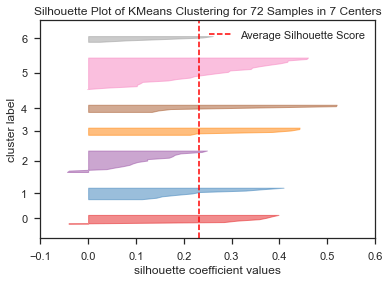

Silhouete Score for 7 Clusters: 0.2317666123261344



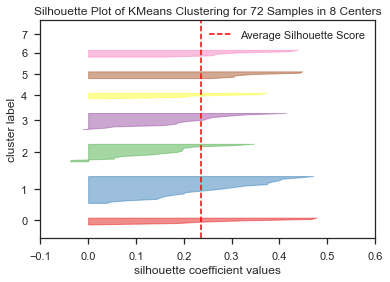

Silhouete Score for 8 Clusters: 0.23505723967663064

2019 Cluster Labels:--------------------------------


,Neighbourhood,Cluster
28,Can Peguera,Cluster 0
29,Canyelles,Cluster 0
30,Ciutat Meridiana,Cluster 0
32,Torre Baró,Cluster 0
33,Vallbona,Cluster 0
39,la Trinitat Nova,Cluster 0
41,Baró de Viver,Cluster 0
47,la Trinitat Vella,Cluster 0
65,la Marina del Prat Vermell,Cluster 0


,Neighbourhood,Cluster
16,Horta,Cluster 1
19,el Baix Guinardó,Cluster 1
20,el Carmel,Cluster 1
21,el Guinardó,Cluster 1
31,Porta,Cluster 1
35,Vilapicina i la Torre Llobeta,Cluster 1
38,la Prosperitat,Cluster 1
42,Navas,Cluster 1
43,Sant Andreu,Cluster 1
46,la Sagrera,Cluster 1


,Neighbourhood,Cluster
10,Vallcarca i els Penitents,Cluster 2
12,el Coll,Cluster 2
13,la Salut,Cluster 2
15,Can Baró,Cluster 2
17,Montbau,Cluster 2
18,Sant Genís dels Agudells,Cluster 2
22,la Font d'en Fargues,Cluster 2
23,la Teixonera,Cluster 2
24,la Vall d'Hebron,Cluster 2
34,Verdun,Cluster 2


,Neighbourhood,Cluster
25,Pedralbes,Cluster 3
57,la Vila Olímpica del Poblenou,Cluster 3
66,Sant Gervasi - Galvany,Cluster 3
67,Sant Gervasi - la Bonanova,Cluster 3
68,Sarrià,Cluster 3
69,Vallvidrera el Tibidabo i les Planes,Cluster 3
70,el Putxet i el Farró,Cluster 3
71,les Tres Torres,Cluster 3


,Neighbourhood,Cluster
0,Sant Pere Santa Caterina i la Ribera,Cluster 4
1,el Barri Gòtic,Cluster 4
2,el Raval,Cluster 4
3,la Barceloneta,Cluster 4
4,Sant Antoni,Cluster 4
5,el Fort Pienc,Cluster 4
6,l'Antiga Esquerra de l'Eixample,Cluster 4
7,la Dreta de l'Eixample,Cluster 4
8,la Nova Esquerra de l'Eixample,Cluster 4
9,la Sagrada Família,Cluster 4


In [78]:
# get optimum PCA number and K for Kmeans for every year
dict_of_img_paths = {}
dict_of_clusters = {}
for year in range(2015,2020,1):
    list_of_img_paths = []
    a = pd.DataFrame(d[year])
    X = np.array(a.iloc[:,2:16])
    pca = PCA()
    pca.fit(X)
    # create figure
    fig = plt.figure(figsize=(13, 6))
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0))
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=1)
    
    
    # plot PCA explained variance
    ax1.plot(range(1,15,1), pca.explained_variance_ratio_.cumsum(),
             marker='o', linestyle='--')

    ax1.set_title('Explained Variance by Components ' + str(year), fontsize=17 )
    ax1.set_xlabel('Number of PCA components')
    ax1.set_xticks(np.arange(1,15,1))
    ax1.set_ylabel('Cumulative Explained Variance')
    ax1.axvline(x = 7, ymin = 0, color = 'red', linewidth =2, ls = ':' )
    
    # plot elbow graphic to evaluate distorsion score 
    pca = PCA(n_components=7)
    pca.fit(X)
    barris_pca = pca.transform(X)
    
    wcss = []
    for i in range(1,9):
        kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=1)
        kmeans_pca.fit(barris_pca)
        wcss.append(kmeans_pca.inertia_)

    
    ax2.plot(range(1,9), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within Cluster Sum of Squares WCSS')
    ax2.set_title('Definition of Clustering '+ str(year), fontsize=17)
    ax2.axvline(x = 5, ymin = 0, color = 'red', linewidth =2, ls = ':' )
    plt.tight_layout()
    plt.savefig(r"C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\pca_elbow_graph_and distorsion_score_" + str(year) +".png",bbox_inches="tight")
    plt.show()
    plt.close()
    
    # plot silhouette to evaluate clustering with different K

    for x in range(2,9):
        model_clust = KMeans(n_clusters=x, random_state=1)
        sil_visualizer = SilhouetteVisualizer(model_clust, color='dark')
        sil_visualizer.fit(barris_pca)
        sil_visualizer.show()
        print(f'Silhouete Score for {x} Clusters: {sil_visualizer.silhouette_score_}\n')
        
   

    # ploting 3d
    sb.set_style('ticks')
    kmeans = KMeans(n_clusters=5, random_state=1).fit(barris_pca)

    # Predicting the clusters
    labels = kmeans.predict(barris_pca)
    # Getting the cluster centers
    C = kmeans.cluster_centers_
    fancy_names_for_labels = [f"Cluster {label}" for label in labels]
    hoods = list(df['neighbourhood'])
    clusters = pd.DataFrame(zip(hoods,fancy_names_for_labels),columns=["Neighbourhood","Cluster"])
    dict_of_clusters[year] = clusters
    print(str(year)+' Cluster Labels:--------------------------------')
    for cluster in list(sorted(set(clusters['Cluster']))):
        display(clusters[clusters['Cluster']== cluster])

    # work with colors for each cluster since every year colours different
#    label_color_map = {0:'#00ced1',
#                       1:'#ffdf00',
#                       2:'#ff4500',
#                       3:'#7b25ea',
#                       4:'#499013',
#                      }
    
#    label_color = [label_color_map[l] for l in labels]
    
#    for i in range(0,360,1):       
        # Plot in 3D since we reduced to three dimensions
#        fig = plt.figure(figsize=(5,5))
#        ax = Axes3D(fig, azim=i, auto_add_to_figure=False)
#        fig.add_axes(ax)
#        ax.scatter(barris_pca[:, 0], barris_pca[:, 1], barris_pca[:, 2], c=label_color,s=75, alpha=0.85, linewidths=0.5, edgecolors='dimgray'  )

        
     #   for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    #        axis.set_ticklabels([])
   #         axis._axinfo['axisline']['linewidth'] = 1
  #          axis._axinfo['axisline']['color'] = (0, 0, 0)
       #     axis._axinfo['grid']['linewidth'] = 0.5
      #      axis._axinfo['grid']['linestyle'] = ":"
     #       axis._axinfo['grid']['color'] = (0, 0, 0)
    #        axis._axinfo['tick']['inward_factor'] = 0.0
   #         axis._axinfo['tick']['outward_factor'] = 0.0
  #          axis.set_pane_color((0.95, 0.95, 0.95))

        
 #       img_path = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\animations\\clustering\\' +str(year)+ '\\clustering' + str(i) + '.png' 
  #      plt.savefig(img_path, bbox_inches="tight")
  #      list_of_img_paths.append(img_path)
 #   dict_of_img_paths[year] = list_of_img_paths

In [79]:
# check dfs of every year to work with info in the clusters
adf = pd.DataFrame(dict_of_clusters[2015])
bdf = pd.DataFrame(dict_of_clusters[2016])
bdf.drop(columns=['Neighbourhood'], inplace=True)
cdf = pd.DataFrame(dict_of_clusters[2017])
cdf.drop(columns=['Neighbourhood'], inplace=True)
ddf = pd.DataFrame(dict_of_clusters[2018])
ddf.drop(columns=['Neighbourhood'], inplace=True)
edf = pd.DataFrame(dict_of_clusters[2019])
edf.drop(columns=['Neighbourhood'], inplace=True)
cluster_df = pd.concat([adf, bdf, cdf, ddf, edf], axis=1)
cluster_df.columns = ['neighbourhood', '2015', '2016', '2017', '2018','2019']
cluster_df.loc[:,:]


,neighbourhood,2015,2016,2017,2018,2019
0,Sant Pere Santa Caterina i la Ribera,Cluster 4,Cluster 4,Cluster 1,Cluster 1,Cluster 4
1,el Barri Gòtic,Cluster 4,Cluster 4,Cluster 1,Cluster 1,Cluster 4
2,el Raval,Cluster 4,Cluster 4,Cluster 1,Cluster 1,Cluster 4
3,la Barceloneta,Cluster 4,Cluster 4,Cluster 1,Cluster 3,Cluster 4
4,Sant Antoni,Cluster 3,Cluster 2,Cluster 1,Cluster 1,Cluster 4
...,...,...,...,...,...,...
67,Sant Gervasi - la Bonanova,Cluster 2,Cluster 3,Cluster 4,Cluster 4,Cluster 3
68,Sarrià,Cluster 2,Cluster 3,Cluster 4,Cluster 4,Cluster 3
69,Vallvidrera el Tibidabo i les Planes,Cluster 2,Cluster 3,Cluster 4,Cluster 4,Cluster 3
70,el Putxet i el Farró,Cluster 3,Cluster 2,Cluster 4,Cluster 4,Cluster 3


In [80]:
# analize clusters obtained by the mean of their features
     
for year in range(2015,2020):
    d = {}
    columns = ['population', '%_unemployed', '% strangers', '% w/ higher education', 'avg_€/m2', 'win_lost_rents_1000_hab', 'disp_income(€/year)','gini_index(%)', 'used_household_purchases', 'new_household_purchases','Total_household_purchases(x1000€)','housing(m2)', 'hostelry(m2)','commerce(m2)', 'offices(m2)']

    for x in range(0,5): 
        c = cluster_df['neighbourhood'].loc[cluster_df[str(year)]=='Cluster '+ str(x)]
        d[x] = list(c)
        
    print(f'\nClusters {year}\n')
    
    filter_1 = df['neighbourhood'].isin(d[0])
    filter_2 = (df['year']==year)
    
    print('\nCluster 0:--------------')
    cluster_0 = df[filter_1 & filter_2]
    display(cluster_0[columns].describe().round(2))

    print('\nCluster 1:--------------')
    filter_1 = df['neighbourhood'].isin(d[1])
    cluster_1 = df[filter_1 & filter_2]
    display(cluster_1[columns].describe().round(2))

    print('\nCluster 2:--------------')
    filter_1 = df['neighbourhood'].isin(d[2])
    cluster_2 = df[filter_1 & filter_2]
    display(cluster_2[columns].describe().round(2))
    
    print('\nCluster 3:--------------')
    filter_1 = df['neighbourhood'].isin(d[3])
    cluster_3 = df[filter_1 & filter_2]
    display(cluster_3[columns].describe().round(2))

    print('\nCluster 4:--------------')
    filter_1 = df['neighbourhood'].isin(d[4])     
    cluster_4 = df[filter_1 & filter_2]
    display(cluster_4[columns].describe().round(2))       


Clusters 2015


Cluster 0:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00
mean,23375.58,6.09,12.56,21.32,9.82,-2.89,18250.65,31.18,153.15,17.12,185.02,787633.88,9589.92,90671.58,26434.31
std,9769.02,0.85,3.84,7.92,0.96,3.70,2573.44,1.98,101.28,34.24,61.20,333428.50,14884.64,47643.68,19191.20
min,9443.00,4.69,5.40,9.60,8.14,-9.40,12474.00,26.82,13.00,0.00,106.60,355936.00,426.00,12293.00,2886.00
25%,15584.00,5.46,11.32,15.38,9.12,-4.80,16791.75,30.04,77.00,0.00,142.25,572072.00,3198.00,67159.50,13160.25
50%,24310.50,6.25,12.40,21.55,9.76,-3.11,18455.50,31.01,131.00,4.50,171.30,772065.00,5175.50,83751.00,21839.00
75%,26915.75,6.72,12.90,26.35,10.40,-1.20,19122.75,32.52,191.25,23.00,224.70,917655.75,10903.75,105901.75,36063.00
max,56682.00,7.98,23.60,39.10,11.50,7.08,24090.00,35.51,419.00,170.00,351.50,1997696.00,77390.00,235811.00,80625.00



Cluster 1:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,7383.78,7.53,14.17,12.68,8.28,-9.02,14269.78,31.79,42.06,3.06,120.94,227851.94,2766.56,31708.28,19635.28
std,4495.92,2.52,6.52,7.98,1.68,11.19,3561.21,2.27,46.86,5.54,51.91,122364.50,3805.70,55941.96,70707.58
min,1145.00,4.37,4.10,4.20,4.89,-32.29,10203.00,26.14,0.00,0.00,59.60,52433.00,0.00,2894.00,0.00
25%,3388.50,5.43,10.22,7.08,6.89,-15.64,11239.00,31.33,8.00,0.00,84.55,122920.00,495.50,9218.25,932.00
50%,7135.00,7.06,12.70,9.20,8.57,-6.21,13056.00,31.94,23.50,0.00,105.84,234330.50,1285.00,14701.00,2563.00
75%,10196.50,9.38,17.32,16.70,9.73,0.23,17046.50,33.40,58.25,4.75,143.62,305167.00,2506.25,32964.75,3995.50
max,15523.00,12.84,27.80,28.90,10.50,4.28,22082.00,34.57,176.00,19.00,261.80,449792.00,13478.00,249897.00,302719.00



Cluster 2:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,15401.33,2.88,12.57,49.45,13.59,-4.65,29749.00,38.59,118.83,12.67,543.22,847305.33,16841.00,62795.50,56879.33
std,8431.23,1.22,2.64,3.63,0.93,7.52,3938.70,1.94,98.13,22.41,178.54,445927.71,6898.88,39927.84,31403.49
min,4635.00,2.14,9.40,42.60,12.20,-11.22,22840.00,34.96,15.00,0.00,309.50,275647.00,6708.00,13373.00,1994.00
25%,9886.50,2.26,10.55,49.08,12.96,-10.16,29055.50,38.63,39.25,1.50,416.25,517255.50,13238.25,32797.50,47476.00
50%,14193.50,2.42,12.40,50.45,14.03,-6.39,29869.50,39.06,107.00,4.50,560.65,870467.00,16696.50,64074.00,61674.50
75%,22616.50,2.65,14.48,51.45,14.21,-2.56,32391.25,39.17,191.25,7.50,640.33,1142390.50,22047.75,86722.50,80995.50
max,25511.00,5.33,16.10,52.80,14.40,8.77,33899.00,40.79,248.00,58.00,793.50,1434701.00,25028.00,118608.00,85754.00



Cluster 3:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00
mean,37379.76,4.71,15.73,38.46,11.50,1.74,22882.65,34.61,235.29,25.88,312.33,1717225.59,75973.82,242452.88,240762.47
std,12289.87,0.74,3.41,7.01,0.62,3.43,3112.63,2.17,130.69,29.23,114.31,764784.28,74923.64,144578.24,263809.31
min,13352.00,2.73,9.80,27.30,10.60,-4.64,19561.00,32.31,45.00,0.00,166.60,541846.00,2788.00,105078.00,28097.00
25%,31645.00,4.62,12.30,33.40,11.13,-0.52,20496.00,32.72,107.00,2.00,235.50,1282451.00,30832.00,130823.00,80246.00
50%,38248.00,4.73,16.60,38.40,11.30,1.42,23093.00,34.05,244.00,20.00,281.70,1496705.00,54485.00,227313.00,162485.00
75%,46086.00,5.07,18.70,43.00,11.74,4.33,24252.00,35.31,298.00,35.00,351.20,2265996.00,96859.00,335439.00,307212.00
max,57711.00,6.01,19.70,50.60,12.60,7.89,31298.00,39.68,490.00,83.00,590.30,3125678.00,326161.00,683754.00,1124680.00



Cluster 4:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,28088.8,7.49,37.72,29.10,12.49,13.88,13976.80,37.29,277.60,19.80,224.42,1034182.80,172623.40,166177.60,165050.60
std,14971.8,0.60,7.63,7.83,2.26,7.41,1740.87,2.88,126.59,18.81,99.82,407914.53,72924.09,68619.08,73912.85
min,15036.0,6.87,29.10,21.90,11.00,4.44,10896.00,34.56,151.00,0.00,143.00,429923.00,69217.00,60663.00,81787.00
25%,15269.0,6.93,31.30,23.50,11.08,9.09,14456.00,34.95,177.00,1.00,150.30,925091.00,124513.00,143570.00,143650.00
50%,22305.0,7.47,39.20,24.90,11.29,13.43,14664.00,36.34,247.00,22.00,193.80,1062094.00,207614.00,177179.00,149320.00
75%,40217.0,8.00,41.10,37.40,12.74,21.18,14714.00,39.52,363.00,37.00,248.70,1214341.00,219691.00,214486.00,166228.00
max,47617.0,8.19,47.90,37.80,16.33,21.23,15154.00,41.09,450.00,39.00,386.30,1539465.00,242082.00,234990.00,284268.00



Clusters 2016


Cluster 0:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00,26.00
mean,22925.77,5.27,13.55,22.37,10.58,-3.48,18424.19,30.97,178.69,14.27,183.72,763806.58,6501.50,85936.96,24963.54
std,10534.23,0.80,3.75,7.20,1.06,2.65,2496.98,1.70,117.62,26.40,51.30,358024.72,5616.63,49746.61,20481.07
min,7428.00,3.78,5.80,11.10,8.77,-8.46,12392.00,26.61,17.00,0.00,113.30,265727.00,472.00,12293.00,2886.00
25%,14417.50,4.76,12.50,16.73,10.01,-4.80,16953.25,30.05,91.50,1.25,150.12,518908.75,2311.25,60420.50,10624.50
50%,24546.50,5.34,13.60,23.20,10.70,-3.60,18822.00,31.07,156.50,2.50,168.50,776076.50,4879.50,83425.50,21228.00
75%,27002.50,5.78,14.28,26.08,11.38,-1.97,19379.25,32.35,241.50,13.25,219.80,917721.75,9391.00,104059.50,31492.50
max,57223.00,7.05,26.10,39.70,12.11,1.22,23984.00,33.43,501.00,98.00,276.30,1998631.00,21918.00,233520.00,81256.00



Cluster 1:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00
mean,7360.00,6.85,15.29,12.22,8.57,-7.95,13907.56,31.30,52.56,3.12,120.24,221445.94,2737.12,32717.19,21746.50
std,4804.29,2.09,6.97,6.94,1.88,6.67,3363.50,2.04,55.25,7.29,52.22,127891.93,4155.67,57966.16,75564.02
min,1151.00,4.47,4.40,5.30,3.52,-21.00,10457.00,25.66,3.00,0.00,55.30,52504.00,0.00,2894.00,0.00
25%,2779.00,4.99,10.85,8.32,7.65,-11.45,11510.50,30.79,10.75,0.00,94.52,103634.75,472.25,9418.75,488.25
50%,6917.00,6.64,13.35,9.15,8.68,-8.73,12659.50,31.66,33.50,0.00,116.70,230627.00,885.00,12137.50,2414.50
75%,10685.25,8.62,19.18,14.45,10.10,-4.51,16861.50,32.26,74.00,0.50,132.98,282456.25,2492.75,32906.25,4142.25
max,15648.00,10.86,28.50,29.80,11.16,5.48,22389.00,34.12,187.00,26.00,271.70,449792.00,13478.00,244185.00,304879.00



Cluster 2:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,36556.67,4.18,17.59,39.27,12.70,2.40,23501.50,34.93,259.39,22.39,330.27,1655230.22,77807.89,237880.83,230808.39
std,13064.98,0.66,3.81,6.87,0.74,4.09,3767.88,2.30,145.60,28.88,105.04,790356.52,75892.43,143468.12,257450.62
min,13710.00,2.42,11.10,29.50,11.67,-7.08,18533.00,32.59,50.00,0.00,199.10,543925.00,2764.00,108109.00,28110.00
25%,30224.75,4.03,14.25,33.35,12.14,0.38,20930.25,33.01,139.50,5.00,264.75,1228168.75,37939.25,126162.25,77603.75
50%,38391.50,4.24,18.25,38.95,12.69,1.53,22546.00,34.73,248.00,12.50,320.45,1473748.50,61446.00,227064.00,147935.00
75%,45639.50,4.50,20.78,43.42,12.96,5.62,25083.25,35.30,338.50,26.75,375.28,2212443.50,91991.75,313875.25,304889.75
max,58315.00,5.16,22.10,50.90,14.26,9.67,33728.00,41.11,518.00,118.00,582.00,3127469.00,341846.00,685399.00,1114090.00



Cluster 3:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00,7.00
mean,15642.86,2.75,13.67,47.89,14.94,-3.55,30941.14,39.03,120.14,13.00,527.64,827437.71,15486.71,60103.86,50570.00
std,7824.34,1.23,2.78,5.47,1.25,7.58,4703.77,3.29,86.34,18.93,142.12,411366.85,7192.74,36862.53,33215.35
min,4689.00,1.83,9.50,39.00,12.60,-15.76,24880.00,34.06,13.00,0.00,293.10,275663.00,6708.00,13373.00,1994.00
25%,10760.50,1.92,12.15,45.25,14.44,-6.70,27985.50,37.07,65.50,0.00,452.10,560223.00,9874.50,36256.50,29309.50
50%,15615.00,2.14,13.50,49.60,15.31,-3.87,30840.00,39.44,112.00,1.00,512.80,807216.00,16215.00,48889.00,52782.00
75%,20883.00,3.34,15.45,51.70,15.82,-0.26,33698.00,41.27,171.50,20.00,651.50,1076267.50,20353.50,83837.00,76730.50
max,25909.00,4.75,17.50,52.70,16.17,8.68,37501.00,43.03,242.00,50.00,680.40,1436204.00,25028.00,118278.00,87134.00



Cluster 4:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,28521.60,6.55,40.58,31.12,13.96,11.72,14175.60,37.73,378.40,35.00,252.86,1036040.20,172380.80,166958.60,161925.60
std,14842.99,0.72,7.86,7.56,2.48,6.51,1879.07,3.37,141.42,48.36,108.23,407752.74,72719.96,68588.05,70823.87
min,15101.00,5.62,30.70,24.20,12.27,3.30,10980.00,34.66,247.00,2.00,155.20,430542.00,69216.00,60611.00,82281.00
25%,16240.00,6.16,34.70,25.40,12.27,7.76,14411.00,35.23,257.00,2.00,181.00,928704.00,124487.00,146169.00,143650.00
50%,22923.00,6.46,41.60,27.40,13.01,11.86,14618.00,36.26,367.00,18.00,212.20,1064955.00,206927.00,177223.00,145507.00
75%,40358.00,7.10,46.30,38.80,14.06,15.91,14939.00,40.08,430.00,35.00,293.10,1216459.00,219798.00,217020.00,161734.00
max,47986.00,7.43,49.60,39.80,18.21,19.79,15930.00,42.42,591.00,118.00,422.80,1539541.00,241476.00,233770.00,276456.00



Clusters 2017


Cluster 0:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,8007.70,4.86,10.87,22.25,11.28,-8.75,18412.70,29.95,52.30,7.10,177.52,278422.30,2996.50,18554.10,6302.80
std,3628.82,1.05,3.72,7.91,1.58,5.89,3053.89,2.69,35.67,7.03,50.56,126562.69,3968.92,11971.34,7315.19
min,2229.00,3.40,4.70,9.40,8.62,-14.97,12507.00,25.32,10.00,0.00,114.40,56595.00,0.00,2894.00,0.00
25%,6024.00,4.24,8.52,17.88,9.90,-13.95,17250.75,28.60,29.00,0.25,141.60,230508.25,802.00,10309.25,3019.75
50%,7304.50,4.42,10.90,22.60,11.86,-9.15,18026.50,30.43,41.00,7.00,166.30,258767.00,1652.50,14709.50,3605.50
75%,9352.25,5.30,14.40,29.42,12.40,-6.01,19494.25,31.78,74.25,11.75,209.25,361960.00,3003.50,22803.50,6195.75
max,15293.00,6.83,14.80,31.50,13.17,2.42,23886.00,33.30,126.00,21.00,277.30,511988.00,13478.00,38526.00,25075.00



Cluster 1:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,35884.47,4.45,24.48,38.67,14.29,5.99,21562.32,35.18,285.05,19.58,374.35,1589761.68,114478.58,243647.89,245784.63
std,14049.59,1.32,11.39,7.30,1.59,5.93,5633.80,2.73,168.25,18.95,121.57,808362.41,85455.37,137227.76,238348.48
min,13681.00,2.22,11.40,25.80,12.95,-2.28,11407.00,32.36,61.00,0.00,197.70,431104.00,21580.00,60680.00,76291.00
25%,23294.50,3.76,18.35,34.35,13.42,1.32,18349.00,33.24,161.00,3.00,293.85,1017109.00,56529.50,156317.50,120611.00
50%,39775.00,4.05,21.50,38.80,13.78,4.98,21495.00,34.53,276.00,19.00,339.60,1498043.00,74703.00,227124.00,157602.00
75%,46878.50,5.10,26.70,43.00,14.45,10.10,24462.50,36.32,387.00,28.50,424.75,2161839.50,131964.00,292393.00,286191.00
max,58238.00,7.25,50.00,51.80,19.84,19.50,35409.00,40.92,709.00,68.00,672.50,3128341.00,348107.00,685965.00,1108278.00



Cluster 2:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,7989.20,7.37,19.65,9.10,8.13,-10.59,12091.40,31.26,84.20,0.40,126.19,224083.30,2540.50,43753.90,32524.50
std,5736.80,1.77,6.74,2.57,2.66,8.80,1096.68,0.88,73.67,1.26,57.37,145729.24,3717.60,71932.57,97431.94
min,1161.00,4.77,9.10,6.10,3.52,-32.07,10554.00,30.00,9.00,0.00,73.60,52504.00,0.00,7444.00,0.00
25%,2624.50,6.29,14.48,7.40,7.00,-12.45,11266.25,30.62,17.25,0.00,97.52,88020.00,438.75,9278.00,162.75
50%,8718.00,7.20,20.35,8.75,8.41,-9.05,11813.50,31.15,90.50,0.00,107.25,222547.50,993.00,22056.00,2266.00
75%,11989.25,8.92,21.78,9.72,10.47,-5.13,12817.00,31.86,106.75,0.00,135.93,331101.50,2244.25,32996.75,2569.50
max,15784.00,9.91,30.10,14.70,11.10,-2.19,13742.00,32.83,237.00,4.00,265.00,449807.00,11042.00,244185.00,309782.00



Cluster 3:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00
mean,25900.44,4.84,15.08,24.06,11.71,-4.25,18426.28,30.58,255.28,20.20,238.04,871749.04,10374.32,99767.76,29944.56
std,9904.69,0.68,3.74,8.15,1.11,4.20,2568.37,1.63,152.62,35.21,74.25,363271.67,15247.93,42949.72,20678.02
min,10307.00,3.67,8.00,11.70,9.45,-18.67,12433.00,27.75,29.00,0.00,132.00,355936.00,472.00,32994.00,7228.00
25%,20766.00,4.36,13.40,17.40,10.89,-5.76,16368.00,29.44,154.00,1.00,172.50,618269.00,3291.00,74247.00,13456.00
50%,25793.00,4.84,14.70,24.60,11.64,-4.25,18907.00,30.36,222.00,4.00,231.60,848738.00,5006.00,90544.00,24355.00
75%,29197.00,5.38,15.10,30.10,12.58,-1.44,19512.00,32.03,333.00,18.00,288.10,950537.00,12736.00,114175.00,38550.00
max,57662.00,6.42,26.60,40.90,13.55,2.65,23771.00,34.12,583.00,124.00,362.50,2018081.00,77013.00,233235.00,80006.00



Cluster 4:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00
mean,17403.88,2.66,13.82,48.89,16.06,-2.38,31182.62,37.85,154.25,15.62,592.74,905816.25,15510.38,67722.50,52758.50
std,8790.43,0.98,2.69,4.99,1.18,7.65,4748.20,2.89,107.23,19.31,194.36,440446.73,6655.01,40500.36,31368.26
min,4710.00,1.80,9.60,40.00,14.13,-15.63,24798.00,33.44,35.00,0.00,337.20,275620.00,6708.00,13373.00,1994.00
25%,11362.50,1.90,12.73,47.90,15.19,-5.09,27925.25,35.76,87.25,0.00,466.90,629328.50,11060.25,40615.75,37359.75
50%,16233.50,2.18,13.85,50.40,16.40,-2.02,31165.50,38.48,122.00,4.50,567.75,875319.00,16023.50,63752.50,60430.00
75%,25309.25,3.38,15.08,52.45,16.90,2.85,34258.00,39.55,215.50,36.00,719.00,1266249.50,18648.75,95910.75,72747.75
max,29691.00,4.28,17.70,53.10,17.45,6.94,38449.00,41.30,346.00,42.00,890.00,1453298.00,25028.00,121656.00,87134.00



Clusters 2018


Cluster 0:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00
mean,8747.11,4.49,12.42,24.40,11.22,-8.11,19211.33,29.20,49.11,6.33,204.00,298080.44,4115.89,21296.11,4563.11
std,3210.97,0.97,4.37,7.04,1.18,6.48,2249.91,2.82,25.06,9.23,52.13,110754.26,4317.22,12630.04,3014.06
min,5185.00,3.18,5.90,12.80,9.47,-19.88,16716.00,25.04,15.00,0.00,155.10,157085.00,708.00,10472.00,1775.00
25%,6884.00,3.98,9.50,18.50,10.05,-12.71,17461.00,26.92,34.00,0.00,162.10,239877.00,1304.00,12595.00,3270.00
50%,7518.00,4.17,13.70,26.00,12.07,-5.69,18607.00,30.00,40.00,4.00,192.00,265538.00,2668.00,18957.00,3745.00
75%,9506.00,4.89,16.20,30.40,12.15,-2.86,19625.00,31.36,62.00,7.00,240.00,377216.00,3325.00,20546.00,4270.00
max,15398.00,6.26,17.10,32.60,12.30,-1.35,23431.00,33.32,99.00,28.00,302.50,511881.00,13478.00,43964.00,11693.00



Cluster 1:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00,16.00
mean,41051.56,3.99,26.79,40.48,14.02,6.42,22297.88,35.44,277.44,16.94,369.61,1774141.69,149543.12,274179.38,250829.12
std,10404.31,1.14,13.11,7.47,0.59,7.96,5774.95,2.94,131.79,13.96,115.62,657513.86,132312.23,147948.57,254373.66
min,19180.00,2.22,12.90,26.70,13.14,-3.11,11736.00,32.08,71.00,0.00,225.50,917255.00,19872.00,142761.00,80096.00
25%,34941.75,3.50,20.03,36.12,13.76,1.66,20092.50,33.73,203.75,3.00,282.30,1234893.25,83721.25,186769.75,105742.75
50%,42711.00,3.70,22.25,40.85,13.93,4.69,21897.50,34.34,234.50,19.00,364.65,1547062.50,110074.00,227674.00,152899.50
75%,48020.25,4.08,27.08,44.92,14.49,10.00,24880.50,37.63,394.00,28.25,393.02,2226993.00,157828.25,323299.50,287040.50
max,58642.00,6.85,56.30,52.50,15.02,27.24,35891.00,41.19,519.00,40.00,644.40,3092140.00,593012.00,759521.00,1066553.00



Cluster 2:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00,11.00
mean,7623.82,6.42,20.35,9.60,9.35,-10.22,12326.82,30.96,74.45,0.09,135.25,208280.09,2452.55,32895.09,26717.45
std,5832.09,1.47,7.18,2.61,2.51,6.22,1021.79,0.64,73.62,0.30,58.93,147657.94,3465.87,43913.86,82724.90
min,1199.00,4.30,10.90,6.70,4.45,-24.09,10610.00,29.65,5.00,0.00,82.00,52325.00,0.00,2623.00,0.00
25%,2425.50,5.30,14.60,8.00,7.41,-12.60,11721.00,30.63,8.50,0.00,89.40,76703.50,294.00,8351.50,392.50
50%,7620.00,5.77,21.80,9.20,10.02,-7.77,12093.00,31.02,66.00,0.00,131.50,213744.00,1299.00,10936.00,2279.00
75%,11721.00,7.96,23.30,10.10,11.48,-6.56,12908.50,31.48,107.50,0.00,156.05,304335.00,2167.00,36841.50,2685.00
max,16250.00,8.12,31.60,15.80,11.97,-3.79,13966.00,31.80,224.00,1.00,281.30,448324.00,10750.00,155093.00,276103.00



Cluster 3:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00,28.00
mean,24729.82,4.48,17.83,26.07,12.38,-4.49,18897.36,30.70,216.39,19.07,249.29,820330.50,22960.57,102834.86,51433.54
std,9753.20,0.69,6.01,8.55,1.28,6.14,2861.56,1.87,135.17,33.94,68.20,342621.18,30377.04,53846.33,68834.17
min,10373.00,3.59,8.60,12.40,10.58,-21.27,12694.00,27.68,24.00,0.00,132.60,355402.00,1118.00,32272.00,8131.00
25%,16091.75,4.02,15.10,19.70,11.55,-6.37,16701.25,29.48,123.75,1.00,200.65,601031.75,5455.00,67335.50,16554.25
50%,25277.50,4.41,16.10,26.30,12.05,-3.52,19348.50,30.32,169.00,8.00,242.10,787837.00,11930.50,95621.50,29958.00
75%,27832.25,4.95,19.10,31.80,13.02,-1.24,20225.75,32.13,305.50,20.25,291.27,940268.50,23202.75,122432.50,47808.50
max,57961.00,6.43,39.10,41.60,16.92,10.18,25043.00,34.68,532.00,167.00,388.40,2021370.00,130687.00,257855.00,356769.00



Cluster 4:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00
mean,17186.38,2.67,15.51,49.72,15.61,-0.39,31570.25,37.73,108.38,15.12,644.92,880995.62,41124.00,72603.75,79481.75
std,8946.93,1.03,3.18,4.84,1.63,5.79,5341.17,3.66,88.95,26.69,200.45,458473.45,49635.53,46518.27,49139.03
min,4727.00,1.81,10.30,41.50,12.07,-10.00,23908.00,32.51,25.00,0.00,383.10,244970.00,13680.00,4829.00,2458.00
25%,11337.00,1.95,13.98,48.85,15.41,-3.07,27985.00,34.74,41.25,0.75,530.05,515327.50,17592.50,33682.25,53921.00
50%,15148.00,2.12,15.20,51.25,16.01,-1.29,32132.00,38.88,83.00,1.50,604.40,873614.00,24320.00,80933.00,81661.50
75%,25379.75,3.29,18.20,53.00,16.54,2.30,34760.50,40.33,152.25,14.00,730.70,1261934.75,34334.75,113068.75,91614.50
max,29875.00,4.41,19.90,53.80,17.18,8.96,39328.00,42.01,292.00,73.00,1000.90,1443816.00,161899.00,123387.00,171627.00



Clusters 2019


Cluster 0:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00
mean,5172.00,6.67,19.12,9.33,8.82,6.62,12579.89,29.59,54.67,0.11,150.37,146383.44,2728.00,27316.78,32533.78
std,3908.32,1.45,9.05,1.87,2.45,10.01,2073.44,2.09,72.95,0.33,68.44,88160.37,3808.46,48738.18,91367.73
min,1227.00,4.34,6.70,7.10,4.46,-3.40,10739.00,24.38,7.00,0.00,84.65,52325.00,0.00,2623.00,0.00
25%,2234.00,5.88,13.60,7.80,7.22,1.40,11660.00,29.46,8.00,0.00,101.85,73188.00,0.00,7587.00,0.00
50%,2925.00,7.32,16.10,9.50,9.48,5.50,12022.00,30.10,10.00,0.00,121.00,106111.00,1299.00,10696.00,2247.00
75%,7669.00,7.92,24.50,10.10,10.07,6.70,12528.00,30.55,69.00,0.00,170.18,233921.00,2486.00,10936.00,4713.00
max,11091.00,8.08,32.80,13.20,12.12,31.00,17878.00,31.42,217.00,1.00,282.13,256608.00,10750.00,155093.00,276103.00



Cluster 1:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00,17.00
mean,30540.71,4.47,18.19,23.39,12.42,3.44,18755.53,29.58,269.06,29.88,250.65,982810.71,12537.53,109485.41,29660.41
std,8415.32,0.55,5.30,7.15,0.80,3.75,2524.13,1.37,125.45,48.59,68.32,328582.62,10580.33,47372.57,15611.86
min,22457.00,3.39,9.70,12.80,10.82,-5.60,12787.00,27.13,109.00,0.00,138.07,617332.00,1118.00,32272.00,8657.00
25%,26168.00,3.96,16.00,16.80,12.05,1.60,16964.00,28.72,160.00,1.00,192.98,808800.00,5471.00,87517.00,20505.00
50%,27813.00,4.48,17.20,24.50,12.42,3.50,19724.00,29.59,274.00,8.00,245.25,909375.00,7547.00,98339.00,28795.00
75%,31352.00,4.93,18.60,28.20,12.92,6.90,20483.00,30.28,319.00,43.00,295.38,958383.00,16196.00,120586.00,34935.00
max,58508.00,5.46,35.00,34.30,13.80,8.20,21811.00,31.80,525.00,181.00,391.28,2023050.00,39137.00,257855.00,70683.00



Cluster 2:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,12635.67,4.40,17.54,25.78,12.36,7.17,19449.89,30.20,88.89,6.83,222.70,413508.72,6235.22,44663.61,18145.11
std,4592.07,0.65,4.58,9.35,1.10,5.09,3728.52,2.16,50.02,7.93,67.02,158476.48,6233.40,36789.81,28997.56
min,5225.00,3.40,8.60,9.80,10.50,-5.30,13014.00,25.61,16.00,0.00,150.45,157085.00,588.00,10472.00,1775.00
25%,9384.25,3.91,15.88,18.55,11.75,4.90,17176.25,29.38,53.00,1.00,175.50,327975.50,1813.25,20470.25,2932.50
50%,13138.00,4.11,17.65,27.30,12.61,7.85,20039.00,29.92,86.00,4.00,198.15,377828.00,3785.00,39444.50,4091.50
75%,15965.25,4.83,20.42,31.70,13.06,10.83,21014.50,31.54,129.50,8.00,258.62,509336.50,8712.75,52048.00,16053.75
max,21523.00,5.56,24.70,42.10,14.10,17.10,26010.00,34.09,185.00,26.00,356.78,694464.00,23172.00,171565.00,101174.00



Cluster 3:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.00,8.0,8.00,8.00,8.00,8.00,8.00,8.00
mean,21559.75,2.41,15.36,51.50,15.89,2.91,35487.75,38.59,128.5,18.12,680.33,1199319.62,36965.62,96787.62,124262.38
std,13928.09,0.82,2.81,3.53,1.23,5.40,4293.89,2.63,88.8,22.69,210.23,881662.91,38132.31,98199.14,166962.32
min,4710.00,1.74,10.60,43.10,13.78,-5.20,29429.00,33.82,15.0,0.00,475.18,244970.00,13680.00,4829.00,2458.00
25%,11298.25,1.90,14.00,51.68,15.19,-0.77,32027.00,38.02,67.5,1.75,528.06,709466.50,17592.50,33747.50,53943.25
50%,20929.50,2.16,15.20,52.20,15.85,3.10,36433.50,39.37,120.0,6.50,655.80,1071934.00,24320.00,80933.00,81661.50
75%,27290.75,2.44,16.68,53.42,16.88,5.92,37723.75,40.36,197.0,31.25,732.51,1442611.50,34334.75,113068.75,91614.50
max,47915.00,4.17,19.40,54.10,17.52,11.70,42055.00,41.16,247.0,62.00,1115.90,3092797.00,128632.00,316771.00,529783.00



Cluster 4:--------------


,population,%_unemployed,% strangers,% w/ higher education,avg_€/m2,win_lost_rents_1000_hab,disp_income(€/year),gini_index(%),used_household_purchases,new_household_purchases,Total_household_purchases(x1000€),housing(m2),hostelry(m2),commerce(m2),offices(m2)
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,35008.05,4.14,28.39,39.31,14.78,-4.86,22351.25,33.89,224.35,15.70,363.74,1416469.25,139140.80,235822.10,215319.30
std,13970.82,1.02,12.69,6.84,0.98,7.99,4700.23,2.26,122.32,17.03,108.16,694893.90,120744.39,148790.34,224986.34
min,13526.00,2.83,13.70,27.20,13.85,-23.40,12142.00,31.40,46.00,0.00,206.72,428055.00,19872.00,51666.00,50381.00
25%,22859.50,3.58,21.10,33.58,14.31,-10.90,19277.25,32.12,141.50,2.00,282.69,954023.50,76692.50,147859.50,94193.50
50%,37194.50,3.76,24.55,39.95,14.48,-3.85,22802.00,33.41,214.50,11.00,348.12,1316137.00,102163.00,213318.00,152899.50
75%,44926.50,4.29,29.17,43.25,15.04,1.90,25430.75,34.14,283.25,21.75,423.51,1969704.50,142620.25,279667.75,221534.00
max,58621.00,6.47,61.90,52.80,17.40,7.80,30341.00,39.64,455.00,62.00,584.08,2889894.00,593012.00,759521.00,1066494.00


In [81]:
# animate images 
#for year in range(2015, 2020, 1):
 #   path_to_save_gif = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\3Dclustering' + str(year) + '_Smaller.gif' 
  #  ims = [imageio.imread(f) for f in dict_of_img_paths[year]]
   # imageio.mimwrite(path_to_save_gif, ims, duration=0.08)

KeyError: 2015

Plot redistribution amongst clusters with sankey diagrams every two years

In [ ]:
# get sankeys
colors = {
    "Cluster 0": "#00ced1",
    "Cluster 1": "#ffdf00",
    "Cluster 2": "#ff4500",
    "Cluster 3": "#8571ba",
    "Cluster 4": "#408b1f",
    "Cluster 5": "#939309"
    }

sankey(cluster_df["2015"], cluster_df["2016"], aspect=20, colorDict=colors, fontsize=12)
img_path = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\sankey2015.png' 
plt.savefig(img_path, bbox_inches="tight")

sankey(cluster_df["2016"], cluster_df["2017"], aspect=20, colorDict=colors, fontsize=12)
img_path = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\sankey2016.png' 
plt.savefig(img_path, bbox_inches="tight")

sankey(cluster_df["2017"], cluster_df["2018"], aspect=20, colorDict=colors, fontsize=12)
img_path = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\sankey2017.png' 
plt.savefig(img_path, bbox_inches="tight")

sankey(cluster_df["2018"], cluster_df["2019"], aspect=20, colorDict=colors, fontsize=12)
img_path = r'C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\PROJECTE\\images\\sankey2018.png' 
plt.savefig(img_path, bbox_inches="tight")


Get the dataframes for every cluster in year 2015.

In [ ]:
i = 0
for year in range(2015,2020):
    print('\nYear---------------',year)
    for cluster in range(0,5):
        print('Cluster '+str(cluster))
        display(cluster_df['neighbourhood'][cluster_df[str(year)]==('Cluster '+ str(cluster))])

___

## Acknoledgements 


KNN imputation , would have supplied missing values in a much easier way than the tailored method I used.

Population/housing(m2) a.k.a density would have provided, in a longer time series, a reflection of the average area of all households from the same neighbourhood and it's trends (if such) , including both rental and proprietary.

___

## Lessons Learned

1. Not all data is made equal: Changes in format, calculus and specially typos, can make this an unnecessary journey.

2. The official may not be official: Errors in Administrations happen just so we spend precious hours re-Checking all code when you can go to the source instead and realise it's their fault.

3. When looking for resources, be a re.findall not a re.match: It feels so frustrating to found better datasets and much more complete when looking for data to be imputated. 

___

## References


Mychal Cohen, Kathryn L.S. Pettit. 2019. ***[Guide to measuring neighborhood change to understand and prevent displacement](https://www.urban.org/sites/default/files/publication/100135/guide_to_measuring_neighborhood_change_to_understand_and_prevent_displacement.pdf)***
 
 
Inside AirBnB Project Web. ***[Historical data from Airbnb](http://insideairbnb.com/barcelona)***


Barcelona City-Council Statistics Department. ***[Official Padron](https://ajuntament.barcelona.cat/estadistica/catala/Estadistiques_per_territori/Barris/Poblacio_i_demografia/Poblacio/Padro_municipal_habitants/index.htm)***


CCMA.TV3 Documentary. 2019. ***[Barraques, l'altra ciutat](https://www.ccma.cat/tv3/alacarta/30-minuts/barraques-laltra-ciutat/video/5372671/)***

Gallego-Vila, Laia . 2018. ***[El barraquismo en la ciudad de Barcelona durante el Franquismo. Primeras aproximaciones a una domesticidad desde los márgenes](https://www.researchgate.net/publication/330676063_El_barraquismo_en_la_ciudad_de_Barcelona_durante_el_Franquismo_Primeras_aproximaciones_a_una_domesticidad_desde_los_margenes)***
